
## 🍊 Orange Telecom 🍊   
### : 고객 행동 예측 및 고객 데이터 분석   
#### 작성자: C4/유재순 (분석날짜: 2026.02.03)  

--- 
**데이터**:  
Orange Telecom 고객 이탈 데이터셋(churn-80, churn-20).   
**분석 목표**:      
Orange Telecom 고객 이탈 데이터셋은 깔끔하게 정리된 고객 활동 데이터(특성들),    
고객이 구독을 취소했는지 여부를 보여주는 이탈 라벨로 구성.예측 모델을 만듬.  

---

## 분석 로드맵

#### 1: 문제 정의 및 데이터 이해
- 데이터 로드 및 기본 구조확인
- 컬럼 목록 및 데이터 타입 확인
- 수치형/범주형 변수 분리

#### 2: 데이터 전처리
- 결측치 확인 및 처리
- 이상치 탐지(IQR기준): 이상치 처리 전략
- 데이터 타입 변환 및 인코딩: Area code 범주형으로 변환, 이진 범수형 인코딩, State 처리 전략(EDA후, 원핫 인코딩 또는 제거)

#### 3: EDA
#### 3-1. 단변량 분석(Univariate Analysis)    
- 수치형 변수: 히스토그램, 박스플롯으로 분포 확인    
- 기술통계량 산출 (평균, 중앙값, 표준편차, 사분위수)    
- 범주형 변수: 빈도표, 막대그래프로 분포 확인    
- 타겟 변수(Churn) 불균형 비율 계산    
#### 3-2. 이변량 분석 (Bivariate Analysis)  
- 수치형 변수 vs Churn: 박스플롯, 바이올린 플롯으로 그룹 간 차이 확인    
- 범주형 변수 vs Churn: 교차표(Crosstab), 스택 바 차트로 이탈률 비교      
- 통계적 검정: t-test (연속형), Chi-square test (범주형)로 유의성 확인   
#### 3-3. 다변량 분석 (Multivariate Analysis) 
- 상관관계 매트릭스(Correlation Matrix) 생성 및 히트맵 시각화  
- 다중공선성 확인 (주간/야간 통화시간-요금 간 높은 상관관계 등)  
- Pair plot으로 변수 간 관계 시각화  
  
**PCA를 통한 차원 축소 및 주요 성분 해석 (선택적)    

#### 4: 모델 학습

#### 5: 모델 평가

#### 6: 모델 해석

#### 7: 비지니스 인사이트 및 액션 플랜

#### 8: 문서화 및 발표 준비

---

### 1. 문제 정의 및 데이터 이해

#### 1-1. 데이터 로드 및 기본 구조 확인

In [2]:
# =========================
# 공통 준비 코드 (맨 위에 1번만 실행)
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1) 데이터 로드
train_df = pd.read_csv("archive/churn-bigml-80.csv")
test_df  = pd.read_csv("archive/churn-bigml-20.csv")

# 2) 컬럼명 공백 제거(공백 때문에 "Churn " 같은 문제가 생기는 걸 방지)
train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

# 3) 타겟 변수명 통일
target = "Churn"

# 4) 수치형 / 범주형 컬럼 리스트 생성 (안전 버전)
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

# 5) 타겟이 numeric_cols에 있을 때만 제거 (없어도 에러 안 남)
if target in numeric_cols:
    numeric_cols.remove(target)

print("공통 준비 완료")
print("train_df shape:", train_df.shape)
print("test_df shape :", test_df.shape)
print("numeric cols:", len(numeric_cols))
print("categorical cols:", len(categorical_cols))


공통 준비 완료
train_df shape: (2666, 20)
test_df shape : (667, 20)
numeric cols: 16
categorical cols: 3


#### 1-2. 컬럼 목록 및 데이터 타입 확인

In [3]:
# =========================
# 1-2. 컬럼 및 데이터 타입
# =========================

print("\n=== Train 컬럼 목록 ===")
print(train_df.columns)

print("\n=== 데이터 타입(dtypes) ===")
print(train_df.dtypes)



=== Train 컬럼 목록 ===
Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

=== 데이터 타입(dtypes) ===
State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charg

#### 1-3. 수치형/범주형 변수 분리

In [4]:
# =========================
# 1-3. 변수 타입 분리 (drop 방식)
# =========================

target = "Churn"

# 수치형에서 target을 제외하고 추출 (errors="ignore"가 핵심)
numeric_cols = (
    train_df.select_dtypes(include=["int64", "float64"])
            .drop(columns=[target], errors="ignore")  # target이 없어도 에러 안 나게 무시
            .columns.tolist()                         # 컬럼 이름만 리스트로 변환
)

# 범주형(object) 변수 추출
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

# =========================
# 추가: 개수 + 목록 출력(보기 좋게)
# =========================

print("\n=== 변수 개수 요약 ===")
print(f"수치형 변수 개수: {len(numeric_cols)}")
print(f"범주형 변수 개수: {len(categorical_cols)}")

print("\n=== 수치형 변수 목록 ===")
for col in numeric_cols:
    print("-", col)

print("\n=== 범주형 변수 목록 ===")
for col in categorical_cols:
    print("-", col)



=== 변수 개수 요약 ===
수치형 변수 개수: 16
범주형 변수 개수: 3

=== 수치형 변수 목록 ===
- Account length
- Area code
- Number vmail messages
- Total day minutes
- Total day calls
- Total day charge
- Total eve minutes
- Total eve calls
- Total eve charge
- Total night minutes
- Total night calls
- Total night charge
- Total intl minutes
- Total intl calls
- Total intl charge
- Customer service calls

=== 범주형 변수 목록 ===
- State
- International plan
- Voice mail plan


================================================================================

### 2. 데이터 전처리

#### 2-1. 결측치 확인 및 처리

In [5]:
# =========================
# 2-1. 결측치 확인
# =========================

import pandas as pd

# 1) 각 컬럼별 결측치 개수
missing_count = train_df.isnull().sum()

# 2) 각 컬럼별 결측치 비율(%)
missing_ratio = (missing_count / len(train_df)) * 100

# 3) 결측치 요약 테이블 생성 (모든 컬럼을 포함)
missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_ratio(%)": missing_ratio
}).sort_values(by="missing_count", ascending=False)

print("=== 결측치 요약 (전체 컬럼) ===")
print(missing_summary)

# 4) 결측치가 있는 컬럼만 따로 보기
missing_only = missing_summary[missing_summary["missing_count"] > 0]

print("\n=== 결측치가 있는 컬럼만 ===")
if missing_only.empty:
    print("결측치가 있는 컬럼이 없습니다. (모든 missing_count = 0)")
else:
    print(missing_only)

# 5) 결측치가 있는 '행'을 실제로 보여주기 (있을 때만)
print("\n=== 결측치가 포함된 행 샘플(최대 5개) ===")
missing_rows = train_df[train_df.isnull().any(axis=1)]

if missing_rows.empty:
    print("결측치가 포함된 행이 없습니다.")
else:
    print(missing_rows.head(5))


=== 결측치 요약 (전체 컬럼) ===
                        missing_count  missing_ratio(%)
State                               0               0.0
Account length                      0               0.0
Area code                           0               0.0
International plan                  0               0.0
Voice mail plan                     0               0.0
Number vmail messages               0               0.0
Total day minutes                   0               0.0
Total day calls                     0               0.0
Total day charge                    0               0.0
Total eve minutes                   0               0.0
Total eve calls                     0               0.0
Total eve charge                    0               0.0
Total night minutes                 0               0.0
Total night calls                   0               0.0
Total night charge                  0               0.0
Total intl minutes                  0               0.0
Total intl calls         

#### 2-2. 이상치 탐지(IQR 기준)

In [6]:
# =========================
# 2-2. 이상치 탐지 (IQR)
# =========================

outlier_info = {}

for col in numeric_cols:
    Q1 = train_df[col].quantile(0.25)   # 1사분위
    Q3 = train_df[col].quantile(0.75)   # 3사분위
    IQR = Q3 - Q1                       # 사분위 범위

    lower = Q1 - 1.5 * IQR              # 하한
    upper = Q3 + 1.5 * IQR              # 상한

    outlier_count = ((train_df[col] < lower) | (train_df[col] > upper)).sum()
    outlier_info[col] = outlier_count

outlier_df = pd.DataFrame.from_dict(
    outlier_info, orient="index", columns=["outlier_count"]
)

print("=== 이상치 개수 요약 ===")
print(outlier_df.sort_values("outlier_count", ascending=False))


=== 이상치 개수 요약 ===
                        outlier_count
Customer service calls            210
Total intl calls                   66
Total intl charge                  40
Total intl minutes                 37
Total night minutes                22
Total night charge                 22
Total day minutes                  21
Total day charge                   21
Total night calls                  19
Total day calls                    18
Total eve minutes                  17
Total eve charge                   17
Total eve calls                    15
Account length                     12
Number vmail messages               2
Area code                           0


---
#### 이상치 처리 전략  
- 통화 시간, 통화 요금, 고객센터 문의 횟수의 큰 값은 데이터 오류가 아니라 실제 '헤비 유저' 또는 '불만 고객'일 가능성이 높음  
→ 이상치로 탐지된 값은 데이터 오류가 아닌 실제 고객 사용 패턴을 반영한 극단값으로 판단되어 제거하지 않았다.
---

### 2-3. 데이터 타입 변환 및 인코딩

In [7]:
# =========================
# 2-3-1. Area code를 범주형으로 변환
# =========================

# Area code는 숫자이지만 크기/연속성 의미가 없으므로 문자열로 변환
train_df["Area code"] = train_df["Area code"].astype(str)
test_df["Area code"] = test_df["Area code"].astype(str)

# categorical_cols에 추가
categorical_cols.append("Area code")

# numeric_cols에서 제거
if "Area code" in numeric_cols:
    numeric_cols.remove("Area code")


In [34]:
# =========================
# 2-3-2. 이진 범주형 인코딩
# yes(가입), no(미가입)
# =========================

binary_map = {"Yes": 1, "No": 0}

binary_cols = ["International plan", "Voice mail plan"]

for col in binary_cols:
    train_df[col] = train_df[col].map(binary_map)
    test_df[col] = test_df[col].map(binary_map)


In [35]:
# =========================
# 2-3-3. State 처리 전략
# =========================

# State는 범주 수가 매우 많으므로
# EDA 및 모델 성능 비교 후
# - 원핫 인코딩 또는 제거 중 하나로 결정할 예정

pass


---
### 이상치 처리 요약 설명  
- IQR 기준으로 이상치를 탐지한 결과, /고객센터 문의 횟수/와 /국제통화/ 관련 변수에서 상대적으로 많은 이상치가 확인되었다.  
그러나 해당 값들은 데이터 오류가 아니라 실제 통화 사용량이 많거나 불만이 누적된 고객의 행동을 반영한 극단값으로 판단되었다.  
본 분석의 목적이 고객 이탈 예측인 점을 고려하여, 이러한 이상치는 비즈니스적으로 중요한 정보로 보고 제거하지 않고 유지하였다.
---

================================================================================

### 3. EDA

================================================================================

### 3-1. 단변량 분석 (Univariate Analysis)  
3-1-1. 수치형 변수: 히스토그램, 박스플롯으로 분포 확인  
3-1-2. 기술통계량 산출 (평균, 중앙값, 표준편차, 사분위수)  
3-1-3. 범주형 변수: 빈도표, 막대그래프로 분포 확인  
3-1-4. 타겟 변수(Churn) 불균형 비율 계산  

**요약:**   
단변량 분석은 각 변수 하나씩만 단독으로 보면서,
값이 어떻게 분포하는지/ 치우쳐 있는지/ 극단값이 있는지/ 범주 비율이 어떤지/확인하는 단계로 "이탈과의 관계"는 보지않음.

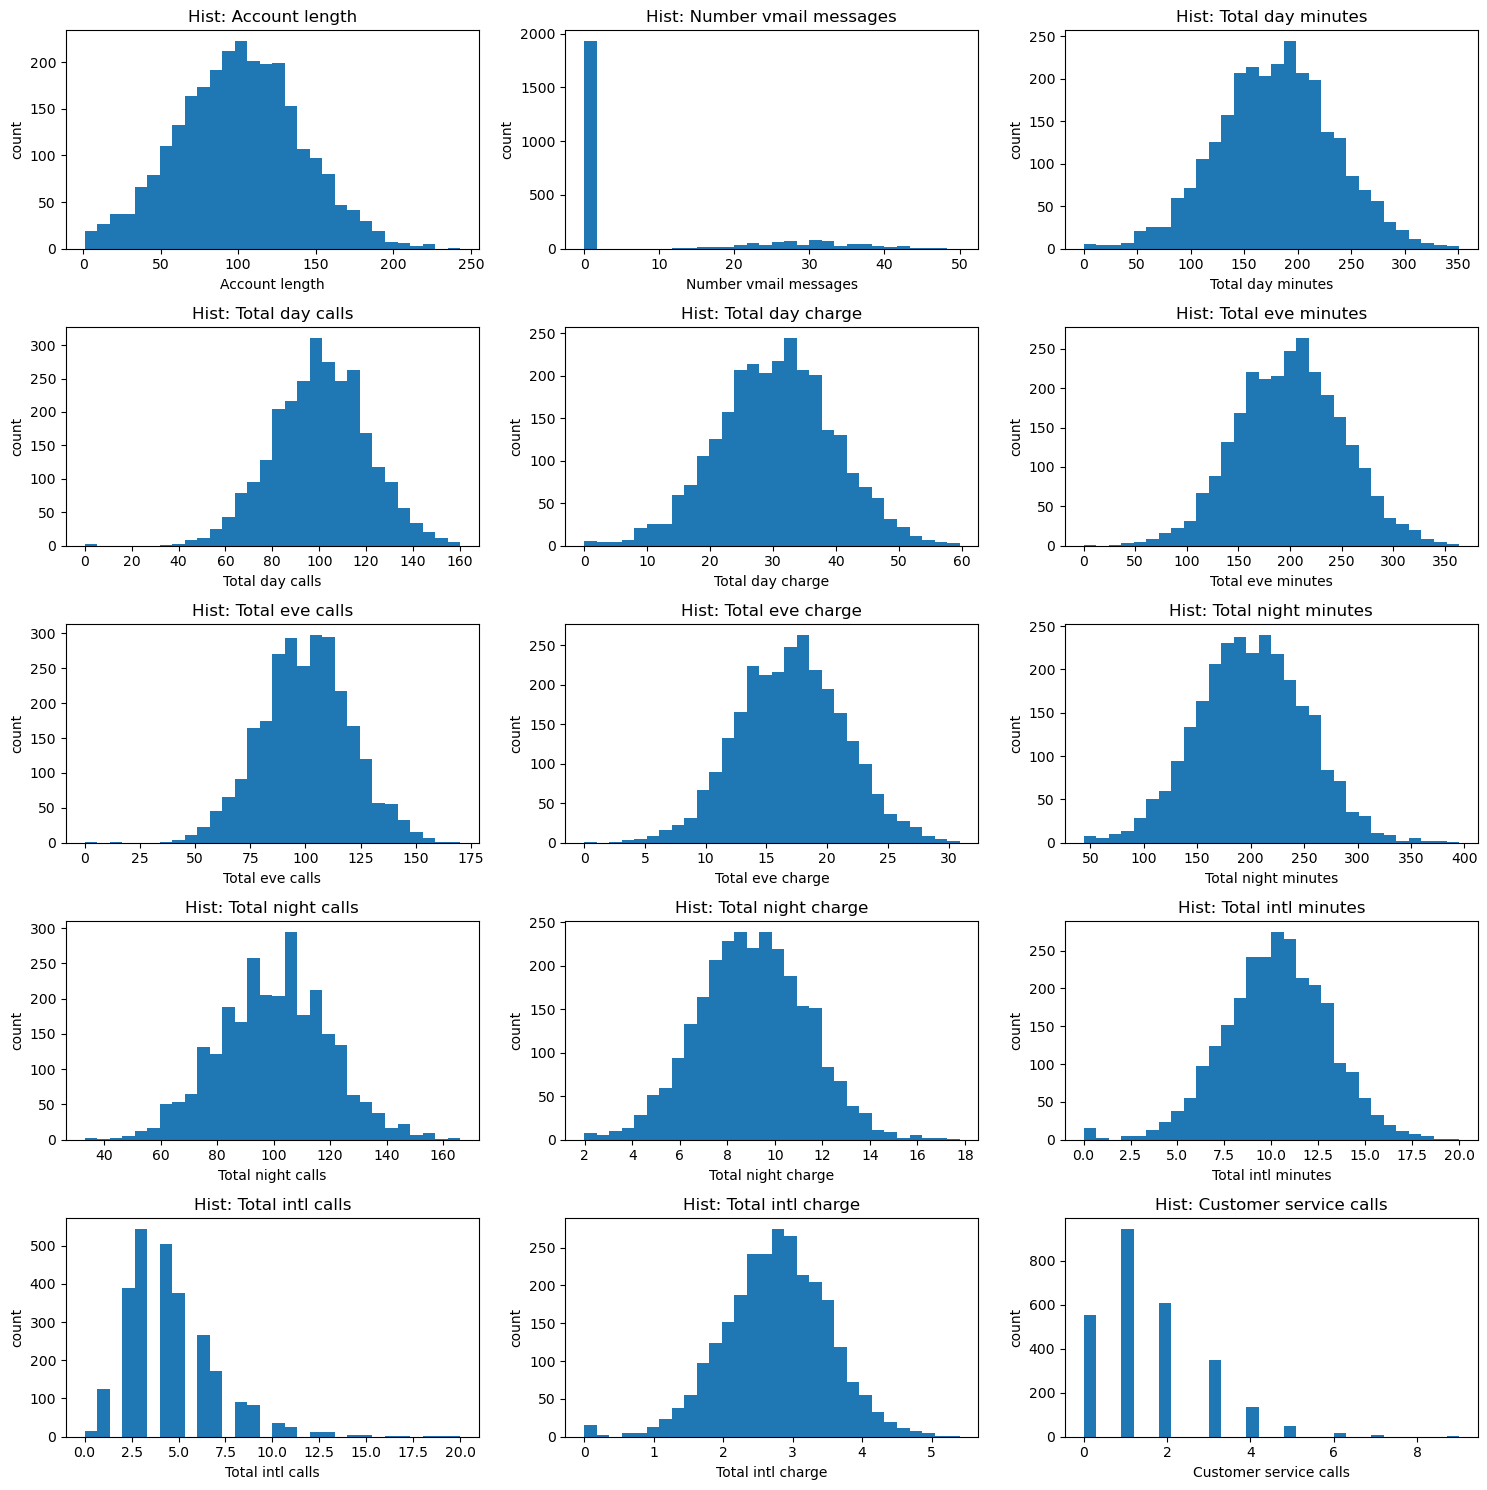

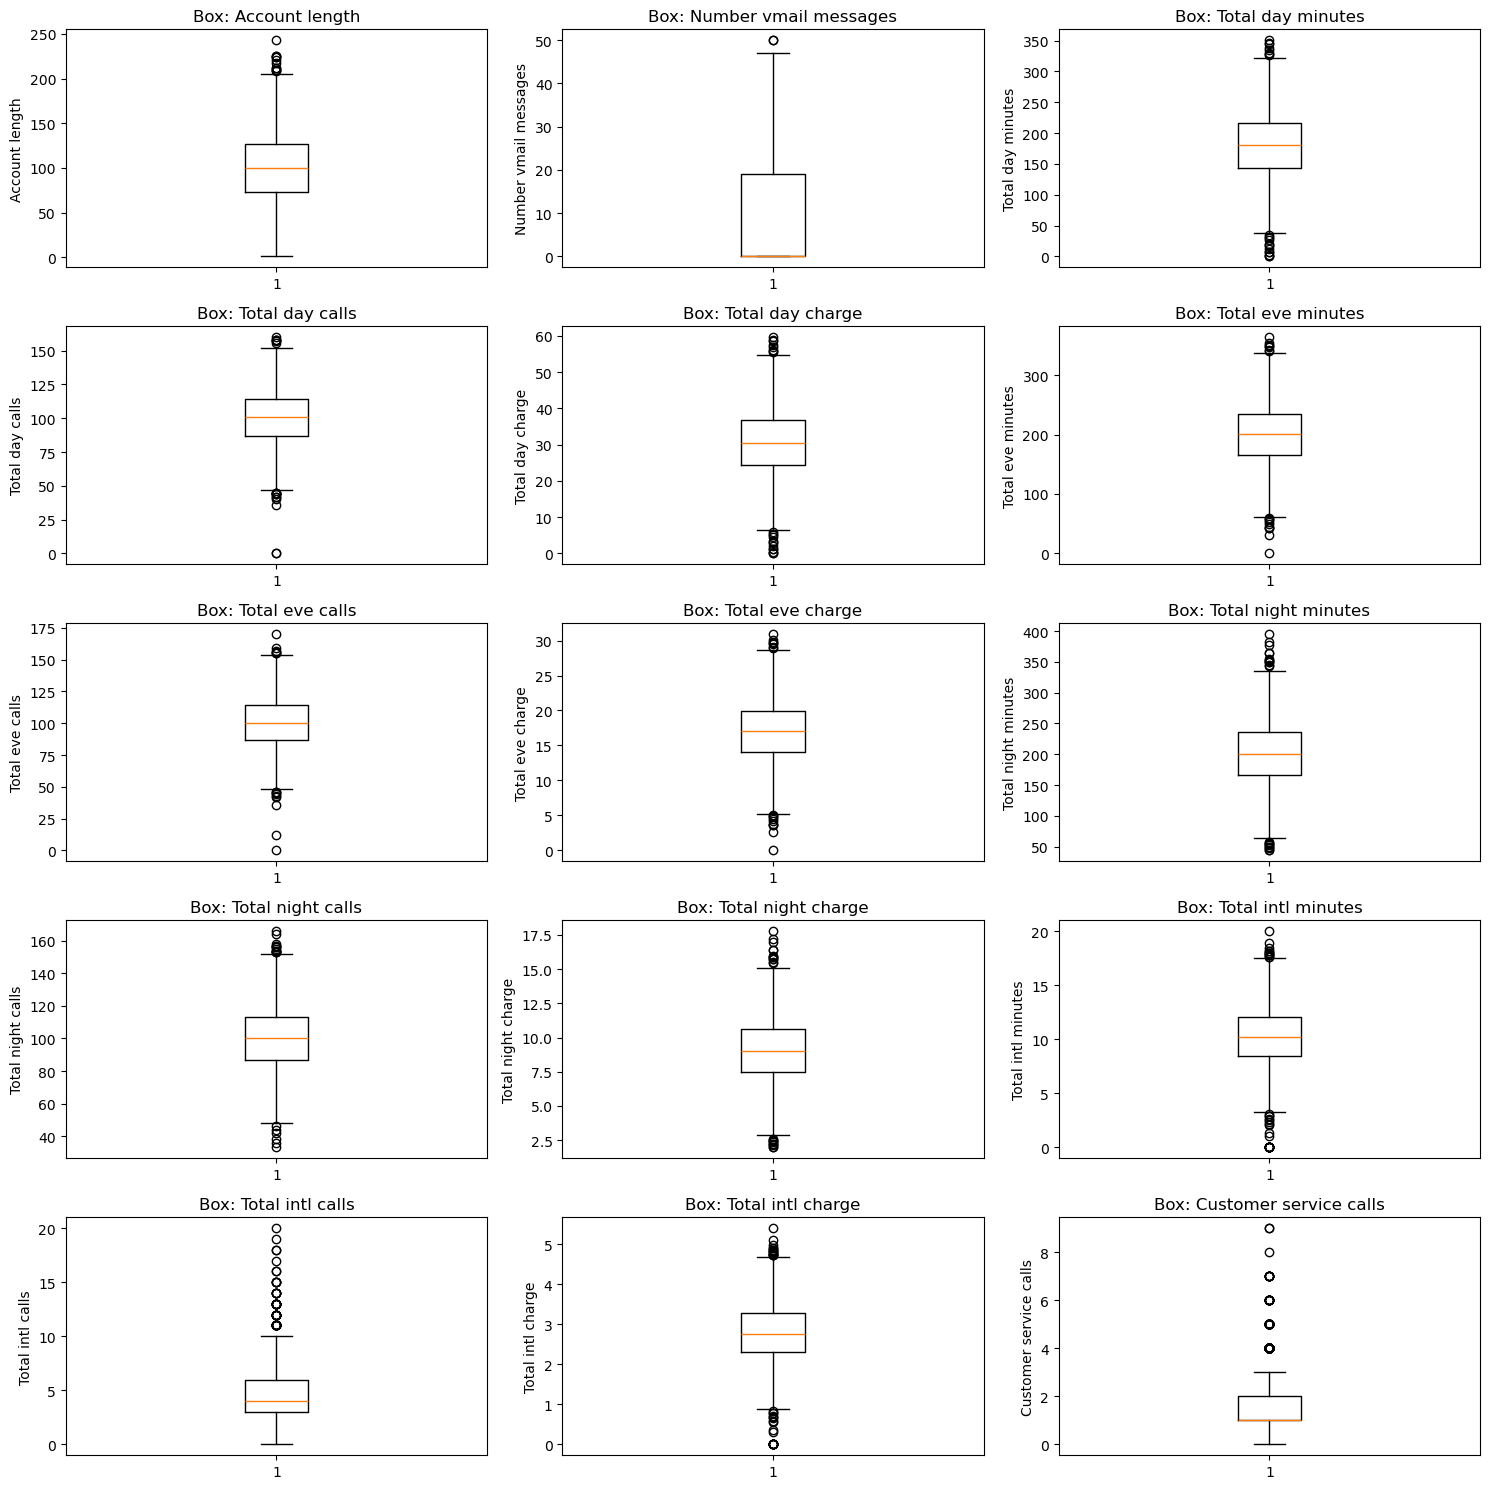

In [10]:
# =========================
# 3-1-1. 수치형 변수 분포 확인 (3개씩 그리드로 출력)
#   1) 히스토그램: 한 줄에 3개씩
#   2) 박스플롯: 한 줄에 3개씩
# =========================

import math
import matplotlib.pyplot as plt

# -------------------------
# (A) 히스토그램: 3개씩 한 줄로 출력
# -------------------------

cols_per_row = 3  # 한 줄에 몇 개 그래프를 놓을지
n = len(numeric_cols)  # 수치형 변수 개수
rows = math.ceil(n / cols_per_row)  # 필요한 행(row) 수 (올림)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 3))
axes = axes.flatten()  # 2차원 배열(axes)을 1차원처럼 다루기 쉽게 펼침

for i, col in enumerate(numeric_cols):
    # i번째 축(axes[i])에 히스토그램 그리기
    axes[i].hist(train_df[col].dropna(), bins=30)
    axes[i].set_title(f"Hist: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")

# 남는 빈 칸(축)은 제거해서 깔끔하게 만들기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # 그래프 간격 자동 정리
plt.show()


# -------------------------
# (B) 박스플롯: 3개씩 한 줄로 출력
# -------------------------

rows = math.ceil(n / cols_per_row)  # 행 수는 동일하게 계산

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # i번째 축(axes[i])에 박스플롯 그리기
    axes[i].boxplot(train_df[col].dropna(), vert=True)
    axes[i].set_title(f"Box: {col}")
    axes[i].set_ylabel(col)

# 남는 빈 칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


---
#### 3-1.1. 히스토그램 & 박스플롯 해석    
**히스토그램:**   
대부분 변수는 안정적인 분포를 보이나,국제 통화 횟수(Total intl calls)와   
고객센터 문의 횟수(Customer service calls)는 0 또는 낮은 값에 데이터가 집중되어 있고,  
일부 고객만 상대적으로 높은 값을 가지는 우측 편향(right-skewed) 분포를 보였다.  
이는 국제 통화나 고객센터 이용이 특정 소수 고객에게 집중되는 특성을 반영한다.  

**박스플롯:**   
통화 시간·통화 요금·국제 통화 관련 변수와 고객센터 문의 횟수에서 다수의 이상치가 관찰되었다.   
 실제 사용 패턴을 반영한 값으로 판단되어 제거하지 않음.  
   
---

#### 3-1-2. 기술통계량 산출(평균, 중앙값, 표준편차, 사분위수)


In [11]:
# =========================
# 3-1-2. 수치형 변수 기술통계량 출력
#   - count(관측치 개수, 결측치없음): 2666
#   - 평균(mean), 표준편차(std)
#   - 사분위수(25%, 50%, 75%) 
#   - min/max (최소값/최대값)
# =========================

# train_df[numeric_cols]는 수치형 컬럼들만 모은 데이터프레임
# describe()는 기술통계량을 한 번에 계산해줌
numeric_summary = train_df[numeric_cols].describe()

print("=== 수치형 변수 기술통계량 ===")  # 출력 제목
print(numeric_summary)                  # 기술통계량 표 출력


=== 수치형 변수 기술통계량 ===
       Account length  Number vmail messages  Total day minutes  \
count     2666.000000            2666.000000         2666.00000   
mean       100.620405               8.021755          179.48162   
std         39.563974              13.612277           54.21035   
min          1.000000               0.000000            0.00000   
25%         73.000000               0.000000          143.40000   
50%        100.000000               0.000000          179.95000   
75%        127.000000              19.000000          215.90000   
max        243.000000              50.000000          350.80000   

       Total day calls  Total day charge  Total eve minutes  Total eve calls  \
count      2666.000000       2666.000000        2666.000000      2666.000000   
mean        100.310203         30.512404         200.386159       100.023631   
std          19.988162          9.215733          50.951515        20.161445   
min           0.000000          0.000000           0.00

---
#### 3-1-2. 기술통계량 결과 해석  
- 수치형 변수의 기술통계량을 확인한 결과, 통화 시간·통화 횟수·요금 관련 변수는 평균과 중앙값이 유사하여 비교적 안정적인 분포를 보였다.  
- 반면, 음성 메시지 수와 국제 통화 관련 변수는 중앙값이 낮고 평균이 상대적으로 높아 소수 고객에 의해 값이 집중되는 편향된 분포 특성을 나타냈다.  
---

### 3-1-3. 범주형 변수: 빈도표, 막대그래프 분포 확인

In [36]:
# =========================
# 3-1-3. 범주형 변수 빈도표(숫자표) 출력
# =========================

# 확인할 범주형 변수(데이터 기준 4개)
cat_cols = ["State", "Area code", "International plan", "Voice mail plan"]

for col in cat_cols:
    print("\n" + "="*40)
    print(f"[빈도표] {col}")

    # value_counts(): 각 범주가 몇 개 있는지 세는 함수
    # dropna=False: 결측치(NaN)도 있으면 같이 세기
    freq = train_df[col].value_counts(dropna=False)

    # State는 종류가 많아서 상위 15개만 보여주고, 나머지는 "기타"로 합쳐서 표시
    if col == "State":
        top_n = 15
        top = freq.head(top_n)
        rest_sum = freq.iloc[top_n:].sum()
        print(top)
        print(f"... 기타 합계: {rest_sum}")
        print(f"총 범주 수: {freq.shape[0]}")  # shape[0] = 행 개수 = 범주 개수
    else:
        # 나머지 변수는 범주 수가 적으니 전부 출력
        print(freq)
        print(f"총 범주 수: {freq.shape[0]}")



[빈도표] State
State
WV    88
MN    70
NY    68
VA    67
WY    66
AL    66
OH    66
OR    62
WI    61
NV    61
UT    60
MD    60
CO    59
CT    59
MI    58
Name: count, dtype: int64
... 기타 합계: 1695
총 범주 수: 51

[빈도표] Area code
Area code
415    1318
510     679
408     669
Name: count, dtype: int64
총 범주 수: 3

[빈도표] International plan
International plan
NaN    2666
Name: count, dtype: int64
총 범주 수: 1

[빈도표] Voice mail plan
Voice mail plan
NaN    2666
Name: count, dtype: int64
총 범주 수: 1


---
### 3-1-3. 빈도표 해석  
- State 변수는 총 51개의 범주로 구성되어 있어 지역을 세밀하게 구분하지만, 각 범주의 관측치가 상대적으로 적어 단독 변수로 활용하기에는 해석 및 모델링 부담이 존재한다.  
- 반면 Area code는 세 개의 범주로 구성된 비교적 거친 지역 구분 변수로, 지역적 특성을 단순화하여 반영한다.  
- International plan과 Voice mail plan은 각각 서비스 가입 여부를 나타내는 이진 변수로, 0은 미가입, 1은 가입 상태를 의미한다.  
---

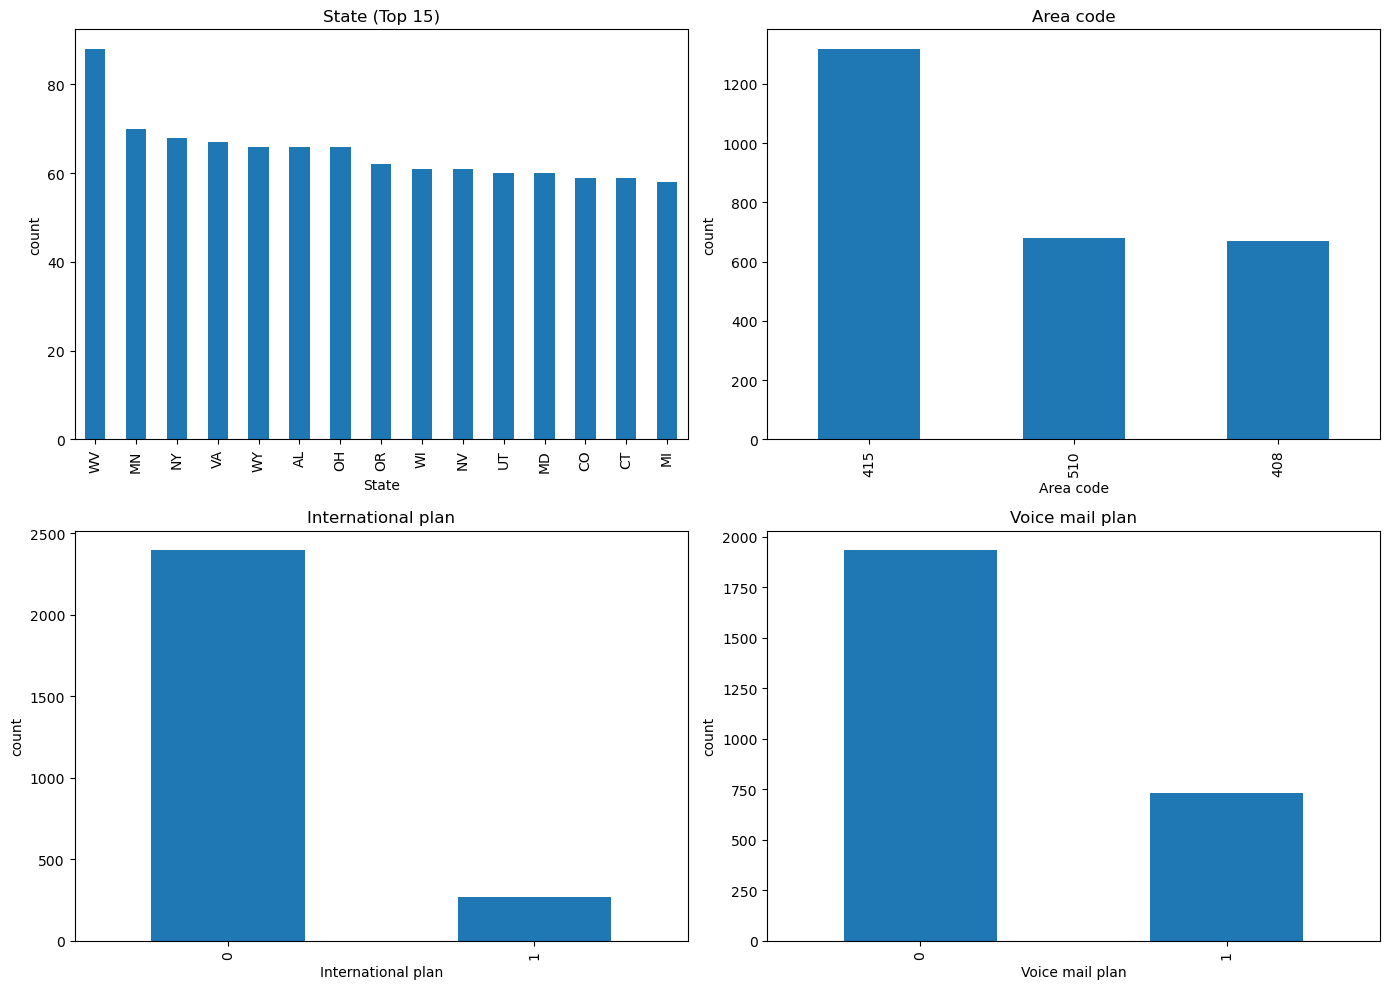

In [13]:
# =========================
# 3-1-3. 범주형 변수 막대그래프 (2x2 한 화면)
# =========================

import matplotlib.pyplot as plt

cat_cols = ["State", "Area code", "International plan", "Voice mail plan"]

# 2행 2열로 subplot(서브플롯) 만들기
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # 2x2 배열을 1차원 리스트처럼 쓰기 위해 변환

for i, col in enumerate(cat_cols):
    ax = axes[i]

    # State는 막대가 너무 많으니 상위 15개만 시각화
    if col == "State":
        train_df[col].value_counts().head(15).plot(kind="bar", ax=ax)
        ax.set_title("State (Top 15)")
        ax.set_xlabel("State")
    else:
        train_df[col].value_counts().plot(kind="bar", ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)

    ax.set_ylabel("count")  # 세로축은 빈도(count)

plt.tight_layout()  # 그래프 겹침 방지
plt.show()


---
#### 3-1-3. 범주형 변수 막대그래프 총괄 해석  

- 범주형 변수 분석 결과,State 변수는 범주 수가 많고 관측치가 분산되어 있어 단변량 분석 단계에서는 해석 효율이 낮다.  
- 반면 Area code는 소수의 범주로 구성된 단순한 지역 구분 변수로 지역 특성을 요약적으로 반영한다.  
- International plan과 Voice mail plan은 서비스 가입 여부를 나타내는 이진 변수로, 0은 미가입, 1은 가입 상태를 의미하며  
  고객을 명확한 상태 집단으로 구분할 수 있어 이탈 분석에 적합한 변수로 판단된다.
- State는 과도하게 세분화된 지역 변수인 반면, Area code와 서비스 가입 여부 변수(0=미가입, 1=가입)는 구조가 단순해 이탈 분석에 유용하다.
---

### 3-1-4. 타겟 변수(Churn)불균형 비율 계산 

=== Churn 개수 ===
0(유지/Stay): 2278
1(이탈/Churn): 388

=== Churn 비율(%) ===
0(유지/Stay): 85.45%
1(이탈/Churn): 14.55%


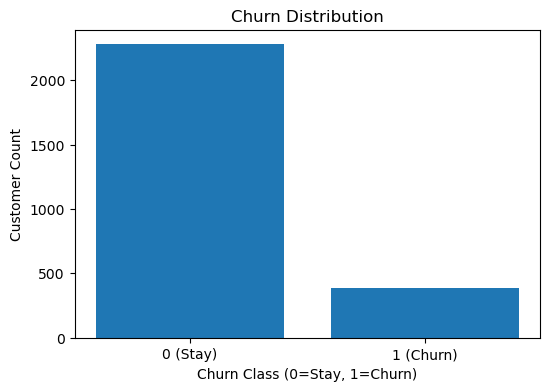

In [14]:
# =========================
# 3-1-4. 타겟 변수(Churn) 불균형 비율 계산
# (개수 + 비율 + 막대그래프)
# =========================

import matplotlib.pyplot as plt

# 1) 타겟 컬럼 이름 설정
target = "Churn"

# 2) Churn이 True/False 형태일 수 있으니, 0/1로 명확히 변환
#    - False(유지) -> 0
#    - True(이탈)  -> 1
train_df["Churn_bin"] = train_df[target].map({False: 0, True: 1})

# 3) 개수(count) 계산
churn_count = train_df["Churn_bin"].value_counts().sort_index()

# 4) 비율(%) 계산
churn_ratio = train_df["Churn_bin"].value_counts(normalize=True).sort_index() * 100

# 5) 출력(개수 + 비율)
print("=== Churn 개수 ===")
print(f"0(유지/Stay): {churn_count.get(0, 0)}")
print(f"1(이탈/Churn): {churn_count.get(1, 0)}")

print("\n=== Churn 비율(%) ===")
print(f"0(유지/Stay): {churn_ratio.get(0, 0):.2f}%")
print(f"1(이탈/Churn): {churn_ratio.get(1, 0):.2f}%")

# 6) 시각화(막대그래프)
plt.figure(figsize=(6, 4))
plt.bar(["0 (Stay)", "1 (Churn)"], churn_count.values)

plt.title("Churn Distribution")
plt.xlabel("Churn Class (0=Stay, 1=Churn)")
plt.ylabel("Customer Count")

plt.show()


---
#### 3-1-4. 타겟 변수(Churn)불균형 비율 결과 해석  
- 타겟 변수인 Churn의 분포를 확인한 결과, 전체 고객 중 유지 고객은 85.45%(2278명), **이탈 고객은 14.55%(388명)** 로 나타났다.  
이는 이탈 고객의 비율이 상대적으로 낮은 클래스 불균형(class imbalance) 데이터임을 의미한다.  

- 따라서 이후 이탈 예측 모델링 단계에서는 단순 정확도(Accuracy)보다는 Precision, Recall, F1-score와 같은 불균형 데이터에 적합한 평가 지표를 함께 고려할 필요가 있다.
또한 데이터 분할 시에도 클래스 비율을 유지하는 방식이 요구된다. 
---


### 3-2. 이변량 분석 (Bivariate Analysis)
3-2-1. 수치형 변수 vs Churn: 박스플롯, 바이올린 플롯으로 그룹 간 차이 확인  
3-2-2. 범주형 변수 vs Churn: 교차표(Crosstab), 스택 바 차트로 이탈률 비교    
3-2-3. 통계적 검정: t-test (연속형), Chi-square test (범주형)로 유의성 확인  
  
**핵심 인사이트 도출:** "고객 서비스 호출이 4회 이상인 고객의 이탈률이 50% 이상" 등   


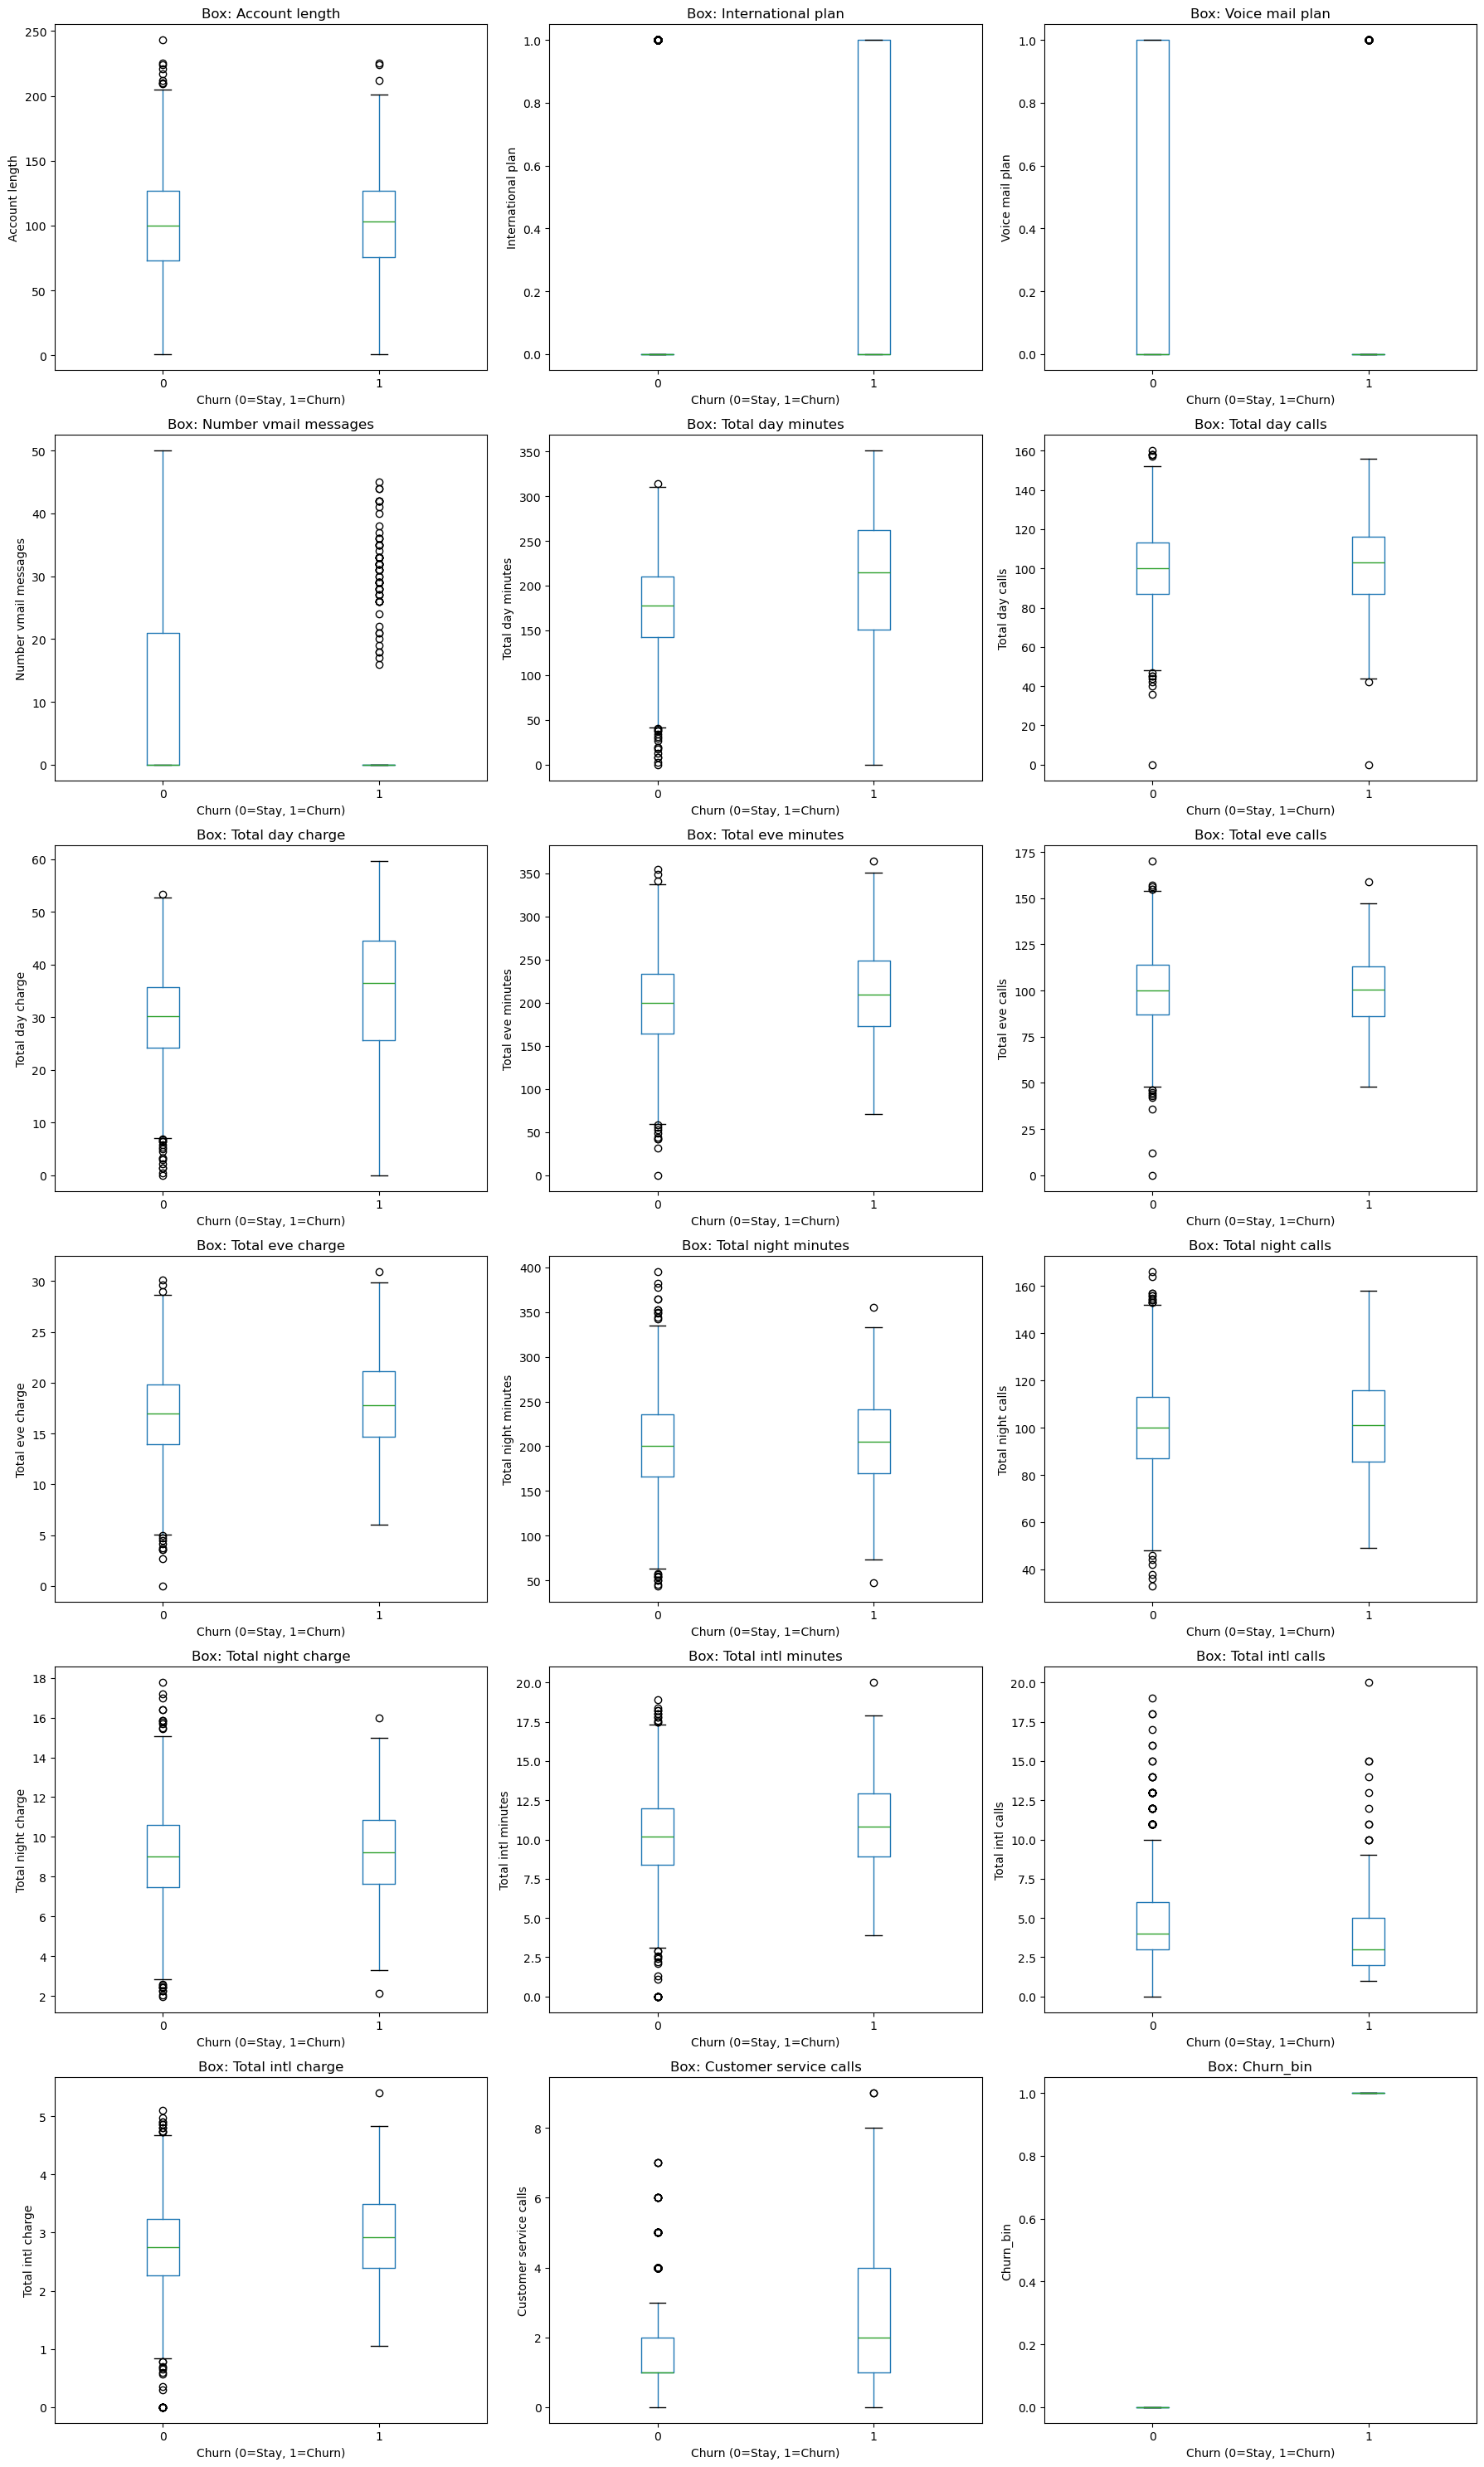

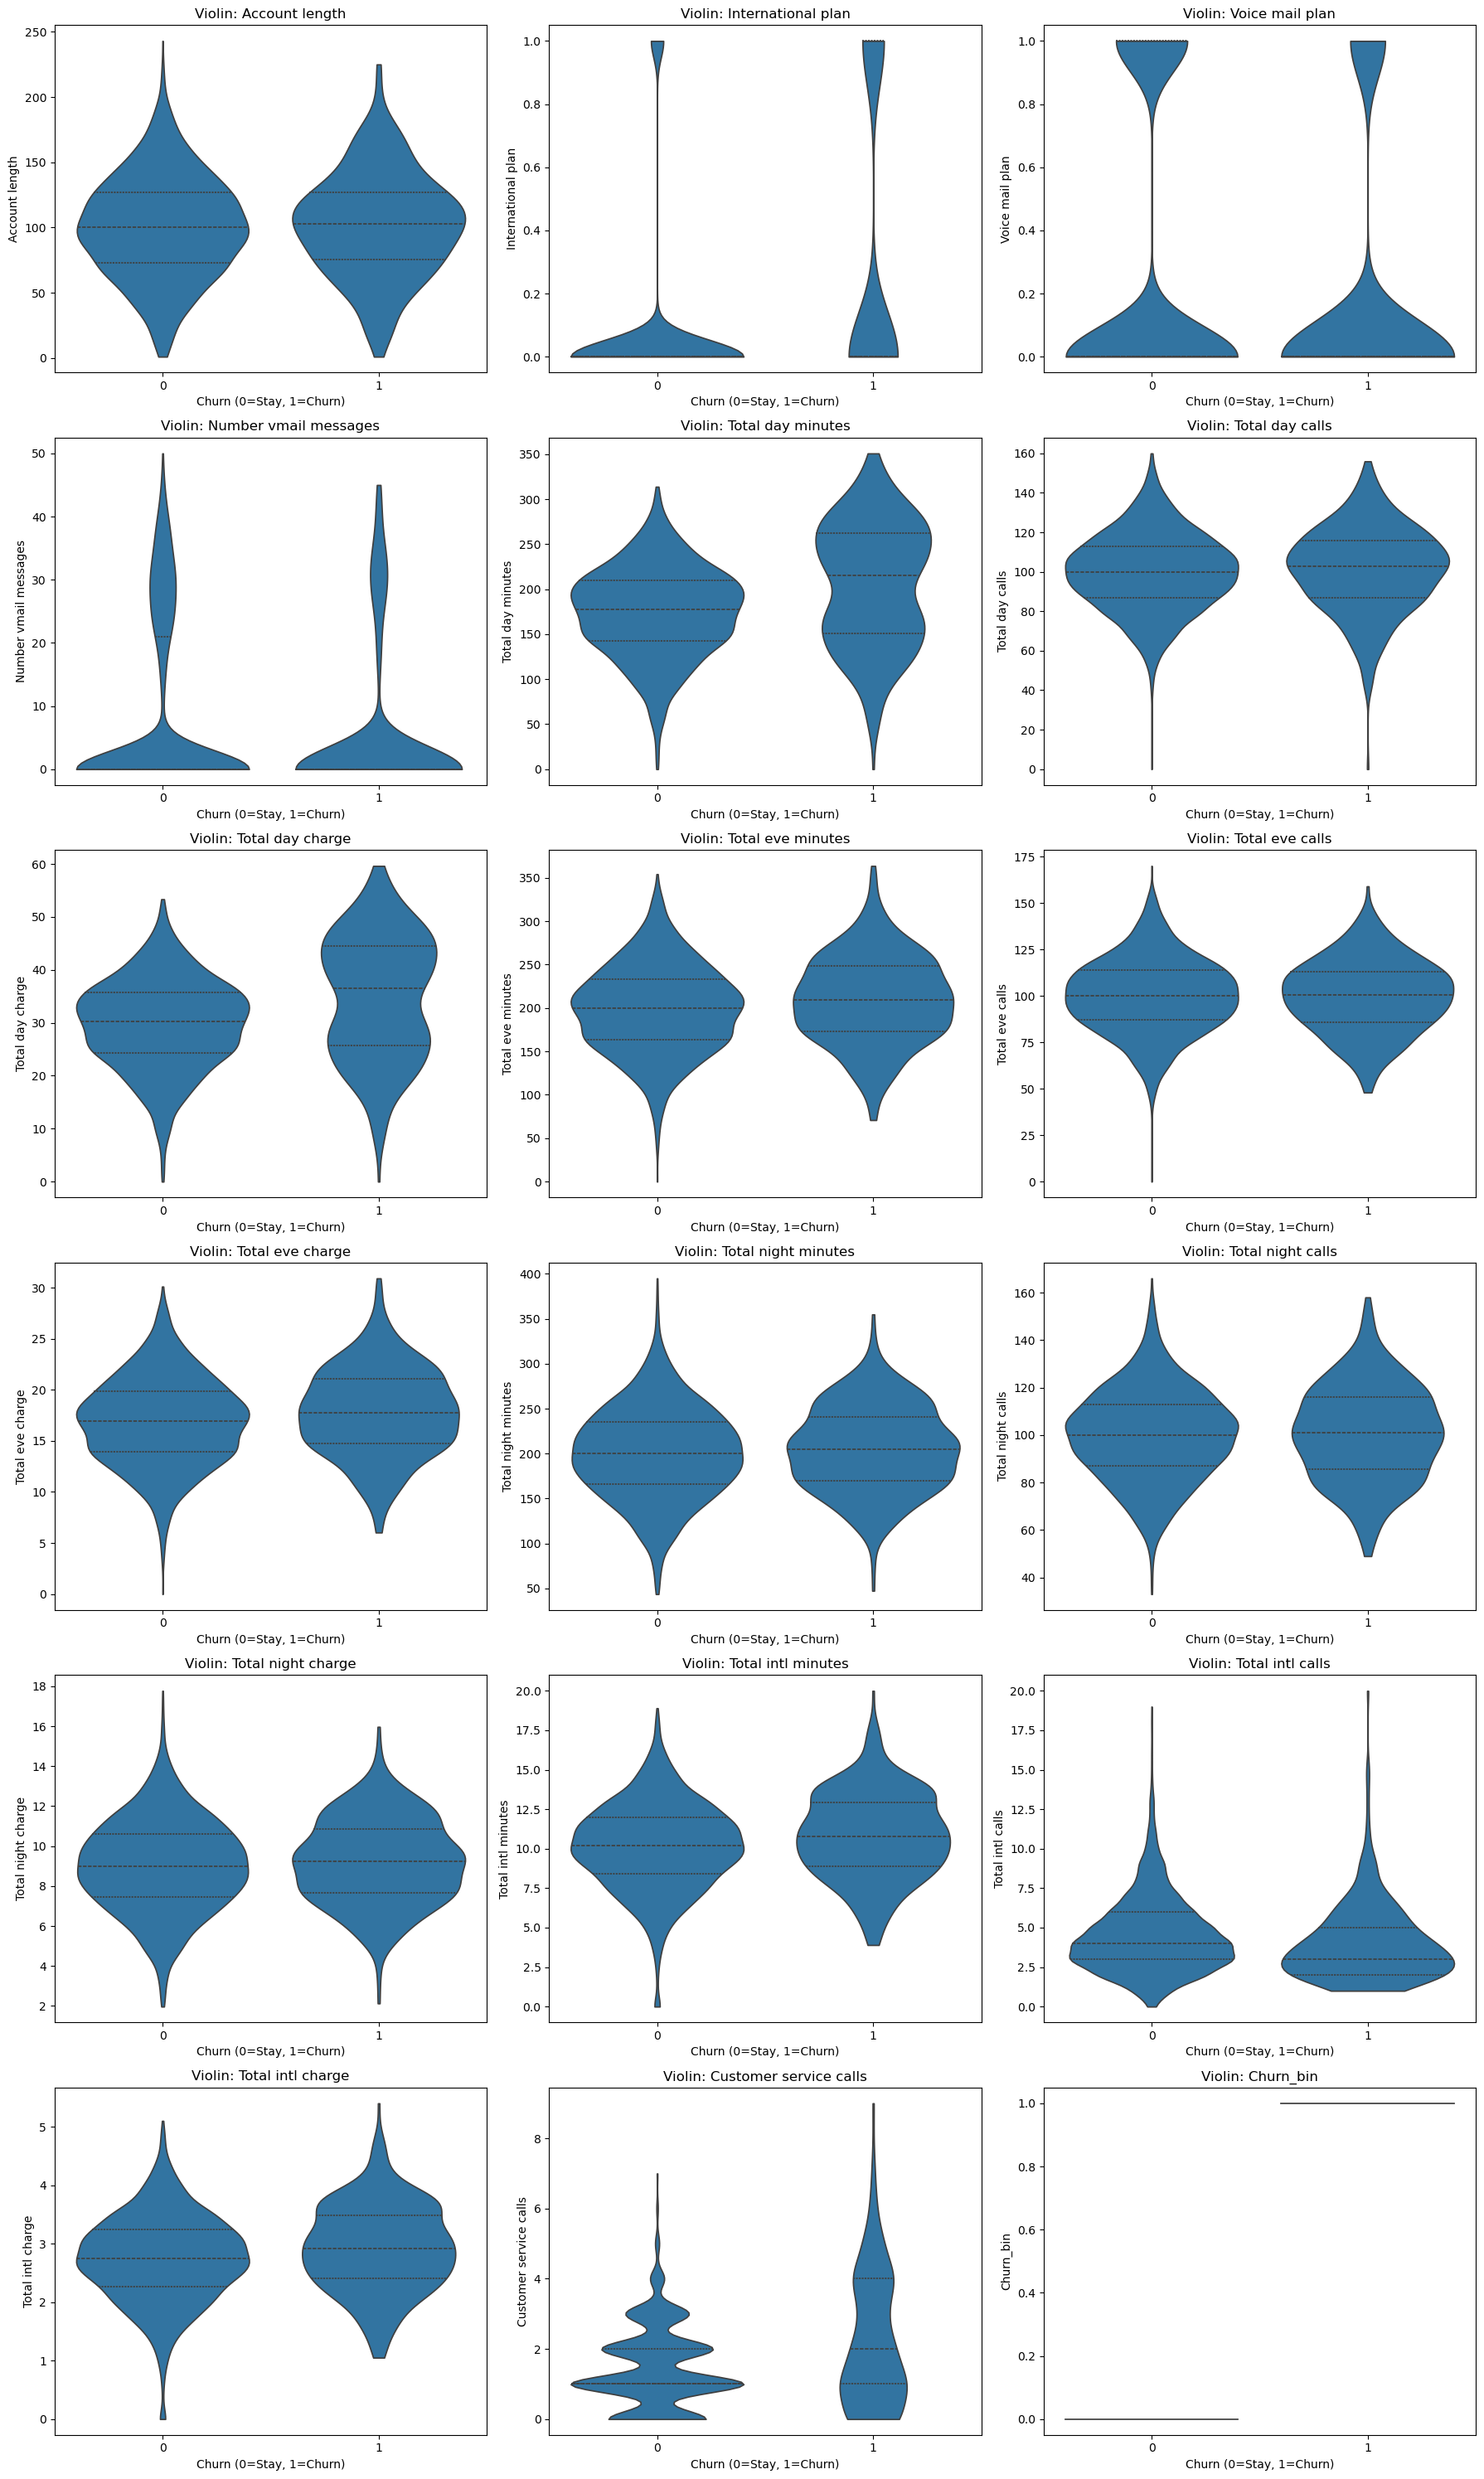

In [15]:
# =========================================================
# 3-2. 이변량 분석 (Bivariate Analysis)
# 3-2-1. 수치형 vs Churn: 박스플롯, 바이올린 플롯
# 3-2-2. 범주형 vs Churn: 교차표, 스택 바 차트
# 3-2-3. 통계 검정: t-test, chi-square test
# + 핵심 인사이트 예시(고객센터 4회 이상 이탈률)
# =========================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 통계 검정용(설치되어 있는 경우가 대부분)
from scipy.stats import ttest_ind, chi2_contingency


# -------------------------
# 0) 기본 설정
# -------------------------
target = "Churn"  # 타겟 변수 이름(이탈 여부)

# 만약 Churn이 True/False로 되어 있으면 0/1로 바꿔서 통일
# - astype(int): True->1, False->0 로 변환
if train_df[target].dtype == "bool":
    train_df[target] = train_df[target].astype(int)

# 수치형/범주형 컬럼 자동 분리
numeric_cols = (
    train_df.select_dtypes(include=["int64", "float64"])
            .drop(columns=[target], errors="ignore")
            .columns.tolist()
)

categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()


# =========================================================
# 3-2-1) 수치형 변수 vs Churn
# 박스플롯: 중앙값/사분위/이상치 비교
# 바이올린: 분포 모양(밀도) 비교
# =========================================================

# 3개씩 한 줄에 보이도록(레이아웃)
cols_per_row = 3

# (1) 박스플롯
plt.figure(figsize=(18, 5 * int(np.ceil(len(numeric_cols) / cols_per_row))))

for i, col in enumerate(numeric_cols, start=1):
    ax = plt.subplot(int(np.ceil(len(numeric_cols) / cols_per_row)), cols_per_row, i)

    # boxplot(by=target): target(0/1) 그룹별로 col 값의 상자그림을 그림
    # grid=False: 격자선 제거
    train_df.boxplot(column=col, by=target, ax=ax, grid=False)

    # 제목/라벨 정리
    ax.set_title(f"Box: {col}")
    ax.set_xlabel("Churn (0=Stay, 1=Churn)")
    ax.set_ylabel(col)

# pandas boxplot은 기본으로 "by="를 쓰면 큰 제목이 생겨서 제거
plt.suptitle("")
plt.tight_layout()
plt.show()


# (2) 바이올린 플롯
# 바이올린은 matplotlib로도 가능하지만, “그룹별 비교”는 seaborn이 훨씬 깔끔함
# seaborn이 없으면 자동으로 박스플롯만 쓰도록 처리
try:
    import seaborn as sns

    plt.figure(figsize=(18, 5 * int(np.ceil(len(numeric_cols) / cols_per_row))))

    for i, col in enumerate(numeric_cols, start=1):
        ax = plt.subplot(int(np.ceil(len(numeric_cols) / cols_per_row)), cols_per_row, i)

        # x=target: 0/1 그룹, y=col: 수치값
        # inner="quartile": 바이올린 안에 사분위수 표시
        sns.violinplot(data=train_df, x=target, y=col, ax=ax, inner="quartile", cut=0)

        ax.set_title(f"Violin: {col}")
        ax.set_xlabel("Churn (0=Stay, 1=Churn)")
        ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()

except ImportError:
    print("seaborn이 설치되어 있지 않아 바이올린 플롯은 생략했습니다.")
    print("필요하면: pip install seaborn")


---
### 3-1-1. 수치형 vs Churn: 박스플롯, 바이올린 플롯 결과 해석

#### 1. 전체 해석 관점 정리

본 분석은
Churn = 0(유지) 그룹과  
Churn = 1(이탈) 그룹 간의 분포 차이를 비교하는 이변량 분석이다.  
박스플롯은 각 변수의 중앙값(50%), 사분위 범위(IQR), 이상치(outlier)를 비교한다.  
바이올린 플롯은 값이 특정 구간에 얼마나 밀집되어 있는지(분포 밀도)를 시각적으로 보여준다.  
즉, 본 분석의 목적은  
이탈 고객과 유지 고객이 실제 사용 행태와 서비스 이용 패턴에서 구조적으로 다른지를 확인하는 것이다.  

#### 2.1 Account length (가입 기간)

유지 그룹과 이탈 그룹의 중앙값과 전체 분포가 거의 유사하다.  
가입 기간이 길거나 짧다고 해서 이탈 여부가 뚜렷하게 구분되지는 않는다.  
요약: 가입 기간은 고객 이탈을 설명하는 핵심 변수로 보기 어렵다.  

#### 2.2 International plan (국제전화 요금제, 0/1)  
이탈 고객 그룹에서 국제전화 요금제 가입 비중이 상대적으로 높다.  
유지 고객 그룹은 대부분 국제전화 요금제 미가입(0)에 집중되어 있다.  
요약: 국제전화 요금제 가입 고객은 상대적으로 이탈 위험이 높다.
이는 요금 부담, 품질 문제, 기대 대비 만족도 저하 가능성을 시사한다.  

#### 2.3 Voice mail plan 및 Number of vmail messages
유지 고객은 음성사서함을 실제로 사용하는 분포가 관찰된다.  
이탈 고객은 음성사서함 사용량이 거의 0에 수렴한다.  
요약: 부가서비스(음성사서함)를 거의 사용하지 않는 고객일수록 서비스 정착도가 낮으며, 이탈 가능성이 높다.  

#### 2.4 Total day minutes / Total day charge (주간 통화 사용량 및 요금)
이탈 고객 그룹의 중앙값이 유지 고객보다 높다.
바이올린 플롯에서도 이탈 고객은 고사용·고요금 구간에 밀집되어 있다.  
요약: 주간 통화 사용량과 요금이 높은 고객일수록 이탈 가능성이 증가한다.
이는 “많이 사용하지만 만족도가 낮은 고객”의 존재를 시사한다.

#### 2.5 Evening / Night 사용량 (minutes, charge, calls)
저녁 및 야간 통화 변수는 두 그룹 간 분포 차이가 상대적으로 작다.  
유지 고객과 이탈 고객의 분포가 상당 부분 겹친다.  
요약: 시간대별 사용량 중에서는 저녁·야간보다 주간 사용량이 이탈과 더 밀접하게 연관되어 있다.  

#### 2.6 International minutes / charge / calls
이탈 고객은 국제 통화 minutes와 charge에서 더 높은 값을 보인다.  
국제 통화 횟수(calls)는 큰 차이가 없으나, 사용 강도는 이탈 고객이 더 높다.  
요약: 국제 통화를 자주 한다기보다, 많은 시간과 비용을 사용하는 고객에서 이탈 위험이 높다.  

#### 2.7 Customer service calls (고객센터 문의 횟수)
유지 고객은 대부분 0~2회 문의에 분포한다.  
이탈 고객은 3~4회 이상부터 분포가 급격히 증가한다.  
바이올린 플롯에서 이탈 고객은 상단으로 긴 꼬리를 형성한다.  
요약: 고객센터 문의 횟수는 이탈을 설명하는 가장 강력한 변수이다.  
특히 문의 횟수 4회 이상은 매우 강력한 이탈 신호로 해석된다.  

#### 3. 종합 패턴 요약

이탈 고객은 다음과 같은 공통적인 특징을 보인다.  
주간 및 국제 통화 사용량이 많다.전체 요금 부담이 높다.
음성사서함 등 부가서비스 활용도가 낮다. 고객센터에 반복적으로 문의한다.  
요약하면, 이탈 고객은“서비스를 많이 사용하지만, 불만이 누적되고 해결되지 않은 고객”으로 정의할 수 있다.

#### 4. 핵심 인사이트 정리  
고객센터 문의 횟수는 이탈을 예측하는 가장 중요한 변수이며, 4회 이상부터 이탈 위험이 급격히 증가한다.  
주간 통화 사용량과 요금이 높은 고사용 고객군은 핵심 이탈 위험 집단이다.  
국제전화 요금제 가입 고객은 상대적으로 높은 이탈률을 보이며, 요금 및 품질 개선이 요구된다.  
부가서비스 활용도가 낮은 고객은 서비스 정착도가 낮아 이탈 가능성이 높다.  



[교차표] State
Churn   0   1
State        
AK     40   3
AL     59   7
AR     36  11
AZ     42   3
CA     19   5
CO     52   7
CT     48  11
DC     40   5
DE     43   8
FL     47   7
GA     41   8
HI     42   2
IA     35   3
ID     51   5
IL     41   4
IN     48   6
KS     42  10
KY     37   6
LA     32   3
MA     44   8
MD     46  14
ME     38  11
MI     45  13
MN     57  13
MO     46   5
MS     37  11
MT     43  10
NC     47   9
ND     40   4
NE     41   4
NH     34   9
NJ     36  14
NM     40   4
NV     48  13
NY     56  12
OH     56  10
OK     45   7
OR     55   7
PA     28   8
RI     45   3
SC     38  11
SD     43   6
TN     36   5
TX     39  16
UT     52   8
VA     63   4
VT     51   6
WA     38  10
WI     57   4
WV     81   7
WY     58   8

[범주별 비율] (행 기준, 각 범주 안에서 0/1 비율)
Churn      0      1
State              
AK     93.02   6.98
AL     89.39  10.61
AR     76.60  23.40
AZ     93.33   6.67
CA     79.17  20.83
CO     88.14  11.86
CT     81.36  18.64
DC     88.89  11.11
DE     84.3

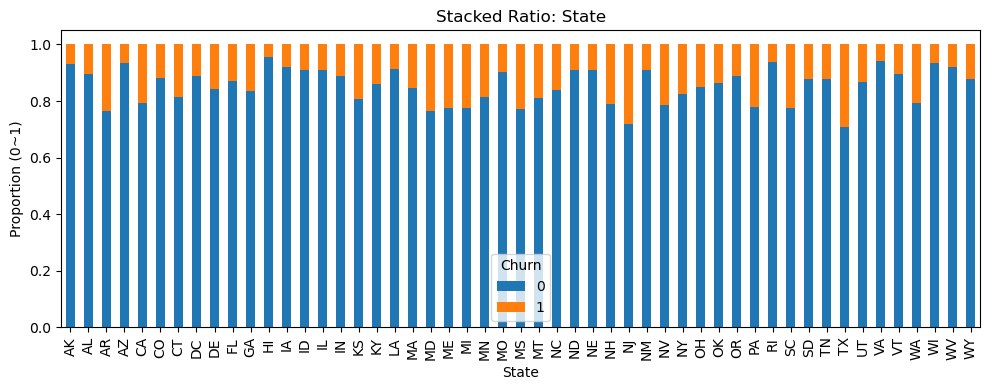


[교차표] Area code
Churn         0    1
Area code           
408         575   94
415        1123  195
510         580   99

[범주별 비율] (행 기준, 각 범주 안에서 0/1 비율)
Churn          0      1
Area code              
408        85.95  14.05
415        85.20  14.80
510        85.42  14.58


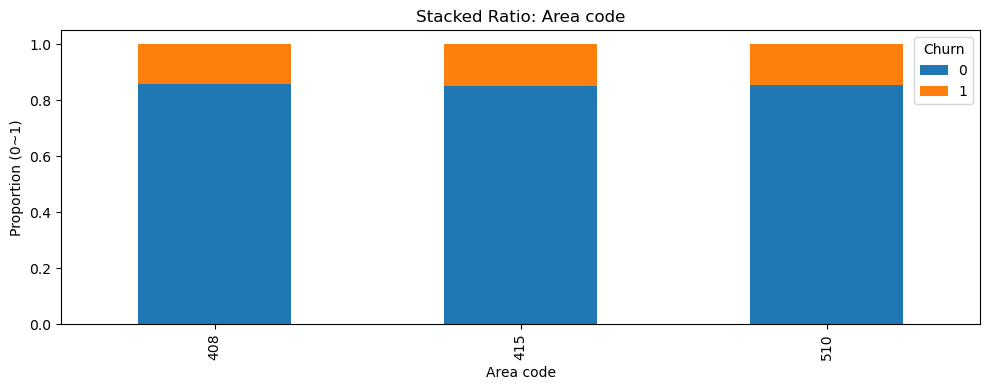

In [16]:
# =========================================================
# 3-2-2) 범주형 변수 vs Churn
# 교차표(Crosstab): 범주별 이탈/유지 카운트
# 스택 바 차트: 범주별 비율(특히 이탈률) 비교
# =========================================================

for col in categorical_cols:
    print("\n" + "=" * 60)
    print(f"[교차표] {col}")

    # pd.crosstab(행=범주, 열=Churn)
    # margins=True: 합계 행/열 추가 (원하면 False로)
    ct = pd.crosstab(train_df[col], train_df[target])
    print(ct)

    # 범주별 비율(행 기준 정규화)
    # div(각 행의 합) : 각 범주에서 0/1 비율로 변환
    ct_ratio = ct.div(ct.sum(axis=1), axis=0)

    print("\n[범주별 비율] (행 기준, 각 범주 안에서 0/1 비율)")
    print((ct_ratio * 100).round(2))  # % 보기 편하게

    # 스택 바 차트
    ax = ct_ratio.plot(kind="bar", stacked=True, figsize=(10, 4))
    ax.set_title(f"Stacked Ratio: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Proportion (0~1)")
    plt.tight_layout()
    plt.show()


### 3-2-2. 범주형 변수 vs Churn 분석 결과 해석  

#### 1. State(주) × Churn  
#### 1.1 교차표 해석  
State별로 고객 수와 이탈(Churn=1) 고객 수가 모두 다르게 분포함  
대부분의 주(State)에서 유지(Churn=0)가 다수, 이탈은 소수  
주별 표본 수가 크지 않은 경우도 많아, 절대값 비교에는 한계 존재  

#### 1.2 범주 내 비율(행 기준 비율) 해석  
전체 평균 이탈률은 약 14~15% 수준  
일부 주(State)에서는 이탈률이 20% 이상으로 상대적으로 높게 나타남  
예: AR, MD, ME, MI, MS 등  
반대로 HI, AK, AZ 등은 이탈률이 5~7% 수준으로 낮음  

#### 1.3 스택 바 차트 해석  
대부분의 State에서 파란색(유지)이 우세  
주별로 이탈 비율 차이는 존재하나,  
전체적으로 State만으로 이탈을 강하게 설명하기는 어려움  
State는 보조적 변수로 해석하는 것이 적절 
 
#### 1.4 중간 결론  
State는 이탈률에 약한 차이는 있으나, 지역 자체가 직접적인 이탈 원인이라기보다는  
다른 요인(요금, 서비스 이용, 고객센터 경험 등)이 결합된 결과일 가능성이 큼  

#### 2. Area code × Churn  
#### 2.1 교차표 해석  
Area code는 3개 범주(408, 415, 510)로 구성됨  
각 Area code별 전체 고객 수는 다르지만,  
이탈 고객 수도 비슷한 비율로 분포  

#### 2.2 범주 내 비율 해석  
Area code별 이탈률  
408: 14.05%  
415: 14.80%  
510: 14.58%  
세 그룹 모두 이탈률이 거의 동일  

#### 2.3 스택 바 차트 해석  
세 Area code 모두 거의 같은 비율의 유지/이탈 구조  
시각적으로도 차이가 거의 없음  

#### 2.4 중간 결론  
Area code는 Churn과 거의 무관  
모델링 관점에서  
예측 기여도가 매우 낮은 변수일 가능성이 높음  
필요 시 제거 후보 변수로 고려 가능  

#### 3. 범주형 변수 분석 종합 결론  
State- 일부 주에서 이탈률 차이는 관찰됨. 하지만 변동성이 크고 표본 수 영향이 큼. 단독으로 강한 설명력은 없음  
Area code-이탈률이 거의 동일. Churn 설명력 매우 낮음.  
전체 요약-  범주형 변수는 이탈의 핵심 요인이라기보다는 보조적 맥락 변수.  
이탈은 지역보다는 고객 행동(통화량, 국제통화, 고객센터 문의 등)  
서비스 경험 변수에서 더 강하게 설명될 가능성이 큼.

In [17]:
# =========================================================
# 3-2-3) 통계적 검정
# - 수치형: t-test (웰치 t-test: 등분산 가정 안 함)
# - 범주형: Chi-square test
# =========================================================

# (A) 수치형: t-test 결과 테이블 만들기
t_results = []

for col in numeric_cols:
    # 그룹 나누기: Churn=0 값들, Churn=1 값들
    g0 = train_df.loc[train_df[target] == 0, col].dropna()
    g1 = train_df.loc[train_df[target] == 1, col].dropna()

    # ttest_ind(a, b, equal_var=False)
    # - equal_var=False: “웰치 t-test” (두 그룹 분산이 다를 수 있다고 보고 검정)
    t_stat, p_val = ttest_ind(g0, g1, equal_var=False)

    # 평균 차이도 같이 저장(해석에 중요)
    mean0 = g0.mean()
    mean1 = g1.mean()

    t_results.append({
        "feature": col,
        "mean_stay(0)": mean0,
        "mean_churn(1)": mean1,
        "mean_diff(1-0)": mean1 - mean0,
        "t_stat": t_stat,
        "p_value": p_val
    })

t_results_df = pd.DataFrame(t_results).sort_values("p_value")
print("\n" + "=" * 60)
print("[t-test 결과] (p_value가 작을수록 Churn 그룹 차이가 뚜렷할 가능성)")
print(t_results_df.head(10))  # 상위 10개만 우선 출력


# (B) 범주형: Chi-square test 결과 테이블
chi_results = []

for col in categorical_cols:
    # 교차표(카운트)
    ct = pd.crosstab(train_df[col], train_df[target])

    # chi2_contingency(교차표)
    # 반환: 카이제곱 통계량 chi2, p값 p, 자유도 dof, 기대도수 expected
    chi2, p, dof, expected = chi2_contingency(ct)

    chi_results.append({
        "feature": col,
        "chi2_stat": chi2,
        "dof": dof,
        "p_value": p
    })

chi_results_df = pd.DataFrame(chi_results).sort_values("p_value")
print("\n" + "=" * 60)
print("[Chi-square test 결과] (p_value가 작을수록 Churn과 연관 가능성)")
print(chi_results_df)



[t-test 결과] (p_value가 작을수록 Churn 그룹 차이가 뚜렷할 가능성)
                   feature  mean_stay(0)  mean_churn(1)  mean_diff(1-0)  \
17               Churn_bin      0.000000       1.000000        1.000000   
1       International plan      0.066725       0.304124        0.237399   
4        Total day minutes    175.104346     205.181186       30.076840   
6         Total day charge     29.768266      34.881340        5.113074   
16  Customer service calls      1.453029       2.206186        0.753157   
2          Voice mail plan      0.293240       0.167526       -0.125714   
3    Number vmail messages      8.507463       5.170103       -3.337360   
15       Total intl charge      2.737709       2.921727        0.184018   
13      Total intl minutes     10.137840      10.819330        0.681490   
7        Total eve minutes    198.853380     209.385309       10.531929   

      t_stat       p_value  
17      -inf  0.000000e+00  
1  -9.907074  5.813590e-21  
4  -8.280870  1.341688e-15  
6  -8.28

/usr/local/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


### 3-2-3. 통계적 검정 결과 해석  
#### 1. t-test 결과 해석 (수치형 변수 vs Churn)  
1.1 해석 기준  
p-value < 0.05  
→ 유지(0) 그룹과 이탈(1) 그룹의 평균 차이가 통계적으로 유의  
mean_diff(1–0)  
→ 이탈 고객이 더 큰 값을 가지는지(+) 또는 더 작은 값을 가지는지(–) 확인  
  
1.2 유의미한 변수 요약 (p-value 매우 작음)    
<u>International plan</u>    
이탈 고객 평균: 0.304  
유지 고객 평균: 0.067  
해석: 국제전화 요금제 가입 고객이 이탈 그룹에 훨씬 많이 포함  
국제 요금제가 이탈 위험 요인일 가능성 높음  
<u>Total day minutes / Total day charge</u>   
이탈 고객의 주간 통화 시간·요금이 유지 고객보다 유의미하게 큼  
해석: 낮 시간대 통화 사용량이 많은 고객일수록 이탈 가능성 증가  
<u>Customer service calls</u>   
유지 고객 평균: 약 1.45회  
이탈 고객 평균: 약 2.21회  
해석: 고객센터 문의 횟수가 많을수록 이탈 가능성 높음  
불만 누적 또는 서비스 문제 신호로 해석 가능  
<u>Total eve minutes / charge</u>   
이탈 고객이 저녁 시간대 통화를 더 많이 사용  
해석: 특정 시간대 사용량 증가가 요금 부담 또는 만족도 저하로 연결될 가능성  
<u>International minutes / charge</u>   
이탈 고객이 국제 통화 사용량과 요금이 더 높음  
해석: 국제 통화 사용 패턴이 이탈과 직접적인 연관  

1.3 반대 방향(이탈 고객이 더 낮은 값)  
<u>Voice mail plan 이탈 고객의 가입 비율이 더 낮음</u>  
해석: 부가 서비스 미가입 고객이 이탈 위험이 더 높을 가능성   
Number vmail messages 이탈 고객의 음성메시지 수가 더 적음
해석: 서비스 활용도가 낮은 고객일수록 이탈 가능성 증가

1.4 Churn_bin 변수  
mean_stay = 0, mean_churn = 1  
t_stat = -inf, p-value = 0  
해석: 타겟 변수 자체이므로 분석적 의미 없음  
이후 분석에서는 반드시 제외해야 하는 변수  
  
#### 2. Chi-square test 결과 해석 (범주형 변수 vs Churn)  
2.1 State  
p-value = 0.004681 (< 0.05)  
해석: State와 Churn 사이에 통계적으로 유의한 연관성 존재  
다만,주(State)가 50개 이상으로 많고 각 범주의 표본 수가 작음
실질적인 설명력은 제한적일 가능성 높음   

2.2 Area code  
p-value = 0.905645 (> 0.05)
해석: Area code와 Churn 사이에 통계적 연관성 없음  
이탈 여부는 지역 코드와 무관    

#### 3. 통계적 검정 종합 결론  
이탈과 강하게 연관된 핵심 변수:  
Customer service calls  
International plan  
Total day / eve minutes & charge  
International minutes & charge  

이탈과 약하거나 무관한 변수:   
Area code (완전히 무관)  
State (통계적 유의성은 있으나 실질 설명력은 낮음)  

이탈 고객의 공통적 특성:  
통화 사용량과 요금이 전반적으로 높음  
국제 통화 사용 비중이 큼  
고객센터 문의 횟수가 많음  
부가 서비스(음성메일 등) 활용도가 낮음  

#### 4. 최종 인사이트 (모델링 관점)  
고객 이탈은 지역적 요인보다 서비스 이용 경험과 비용 부담에서 발생  
특히, 고객센터 문의가 반복되는 고객. 국제 통화 및 고사용량 고객
부가 서비스 미활용 고객은 이탈 고위험군.  
고객센터 호출 횟수, 국제 요금제 여부는 최우선 변수로 유지하는 것이 타당  

In [18]:

# =========================================================
# 3-2-4) 핵심 인사이트 예시
# "고객 서비스 호출이 4회 이상인 고객의 이탈률"
# =========================================================

col_cs = "Customer service calls"

if col_cs in train_df.columns:
    # 조건: 고객센터 문의 횟수 >= 4
    cond = train_df[col_cs] >= 4

    # 이탈률 = (조건 만족 고객 중 Churn=1 비율)
    # mean()은 0/1에서 “평균=1의 비율”이 되는 성질이 있음
    churn_rate_ge4 = train_df.loc[cond, target].mean()

    # 비교를 위해 전체 이탈률도 같이
    churn_rate_all = train_df[target].mean()

    print("\n" + "=" * 60)
    print("[핵심 인사이트 체크]")
    print(f"전체 이탈률: {churn_rate_all*100:.2f}%")
    print(f"{col_cs} >= 4 인 고객 이탈률: {churn_rate_ge4*100:.2f}%")

else:
    print(f"\n'{col_cs}' 컬럼이 train_df에 없습니다. 컬럼명을 확인하세요.")


[핵심 인사이트 체크]
전체 이탈률: 14.55%
Customer service calls >= 4 인 고객 이탈률: 52.86%


---
#### 결과 해석 (핵심 인사이트)  

1. 전체 이탈률: 14.55%  
전체 고객 중 **약 14.6%**가 이탈한 상태  
이 값이 기준선(baseline) 역할을 함  
→ “특정 조건의 고객 이탈률이 이보다 얼마나 높은가?”를 비교하는 기준  

2. 고객센터 문의 4회 이상 고객 이탈률: 52.86%  
Customer service calls ≥ 4 인 고객의 이탈률이 52.86%  
전체 평균 이탈률(14.55%) 대비 약 3.6배 높음  
수치로 비교하면:  
일반 고객: 약 100명 중 15명 이탈  
고객센터 4회 이상 문의 고객: 약 100명 중 53명 이탈  
→ 이건 우연 수준이 아니라 “행동 패턴이 완전히 다른 집단  

3. 의미 해석 (비즈니스 관점)  
고객센터 문의 횟수는 단순 문의가 아니라  
불만 누적, 서비스 문제, 기대 불일치의 신호  
4회 이상 문의했다는 것은:  
문제가 반복적으로 해결되지 않았거나 고객 경험이 지속적으로 나빴을 가능성이 큼
이탈은 “갑자기” 발생한 것이 아니라 불만이 누적된 결과로 나타난 것  

4. 분석 구조상 의미 (EDA 흐름 기준)  
단변량:  
→ 고객센터 문의 횟수 자체에 분산과 이상치가 많음을 확인  
이변량(시각화 + t-test):  
→ Churn 그룹에서 평균 문의 횟수가 유의하게 높음  
조건부 이탈률 분석(이번 결과):  
→ “어느 수준부터 위험한가?”를 명확히 규정  
즉,단순 상관이 아니라 실제 의사결정에 쓸 수 있는 임계값(threshold) 도출  

1. 최종 인사이트 
전체 고객의 평균 이탈률은 14.55% 수준이었으나, 고객센터 문의가 4회 이상 발생한 고객 집단에서는 이탈률이 52.86%로  
급격히 증가하였다. 이는 고객센터 반복 문의가 단순한 서비스 이용 특성이 아니라, 이탈로 이어지는 핵심 위험 신호임을 시사한다.  

---
### 3-3. **다변량 분석 (Multivariate Analysis)**  
3-3-1. 상관관계 매트릭스(Correlation Matrix) 생성 및 히트맵 시각화  
3-3-2. 다중공선성 확인 (주간/야간 통화시간-요금 간 높은 상관관계 등)  
3-3-3. Scatter Matrix (Pair Plot 대체) 변수 간 관계 시각화  
  
**PCA를 통한 차원 축소 및 주요 성분 해석 (선택적)   


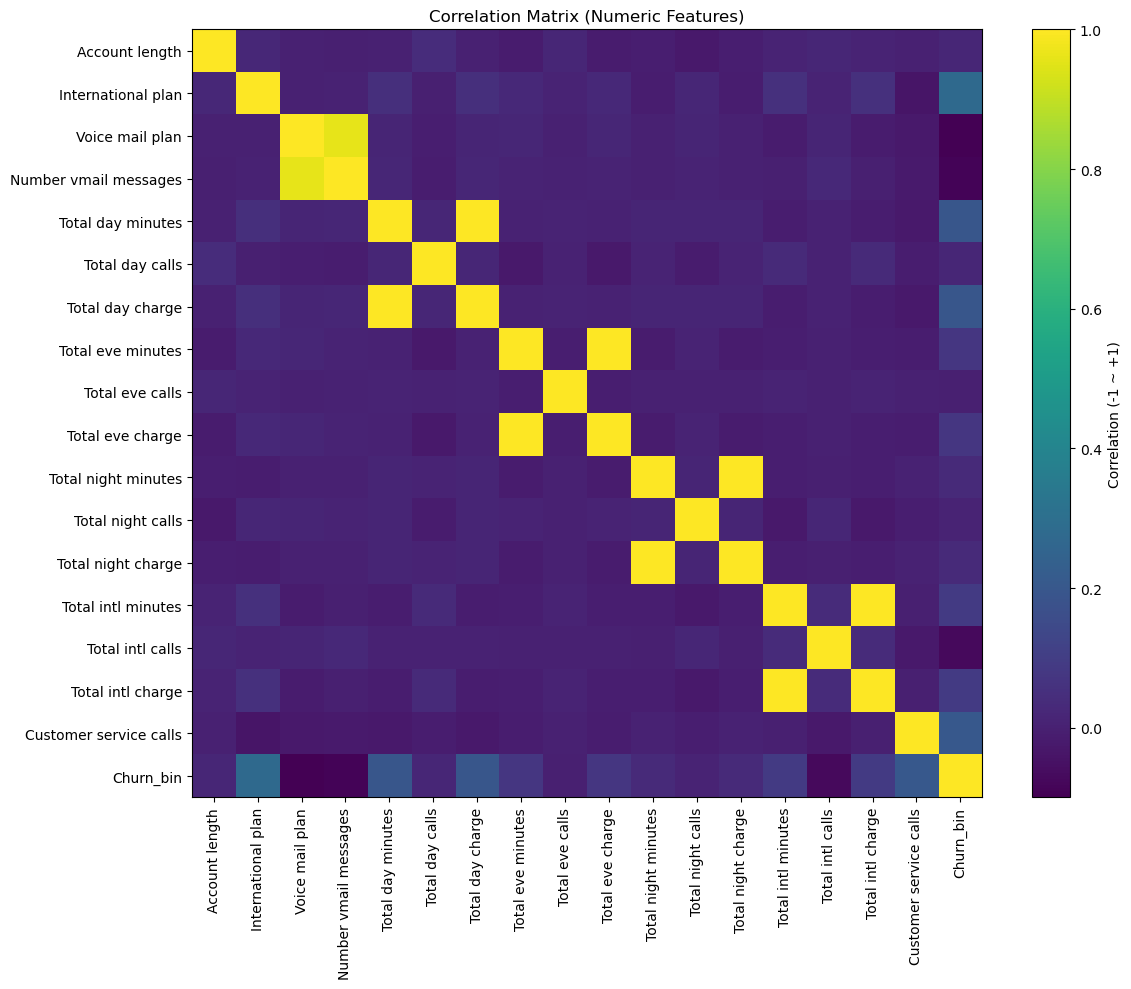


[Churn과의 상관(절댓값 큰 순)]
Churn_bin                 1.000000
International plan        0.277489
Customer service calls    0.202590
Total day charge          0.195689
Total day minutes         0.195688
Voice mail plan          -0.099291
Number vmail messages    -0.086474
Total intl charge         0.086216
Total intl minutes        0.086204
Total eve minutes         0.072906
Total eve charge          0.072893
Total intl calls         -0.069882
Total night minutes       0.033639
Total night charge        0.033635
Total day calls           0.018290
Account length            0.017728
Total night calls         0.012262
Total eve calls          -0.001539
dtype: float64


In [19]:
# =========================
# 3-3-1. 상관관계 매트릭스(Correlation Matrix) + Heatmap
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1) 수치형 변수들끼리 상관계수(피어슨) 계산
# - corr() : 각 변수쌍의 상관계수( -1 ~ +1 )를 계산
corr_mat = train_df[numeric_cols].corr()

# 2) 히트맵(Heatmap) 그리기
# - imshow() : 행렬을 색으로 표현
# - 값이 많으면 글자가 겹치므로, 필요하면 figsize를 키우거나 변수 일부만 선택해도 됨
plt.figure(figsize=(12, 10))
plt.imshow(corr_mat.values, aspect="auto")
plt.colorbar(label="Correlation (-1 ~ +1)")

# 축에 변수명 표시
plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
plt.yticks(range(len(corr_mat.index)), corr_mat.index)

plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

# 3) (선택) 특정 변수(타겟)와의 상관도도 같이 보고 싶으면
# - Churn이 True/False라면 0/1로 바꿔야 corr 계산이 안정적임
churn_bin = train_df[target].astype(int)
corr_with_churn = train_df[numeric_cols].corrwith(churn_bin).sort_values(key=lambda s: s.abs(), ascending=False)

print("\n[Churn과의 상관(절댓값 큰 순)]")
print(corr_with_churn)


상관관계 분석 결과, 이탈(Churn)은 **국제 요금제 가입 여부(International plan)** 와   
**고객센터 문의 횟수(Customer service calls)** 와 상대적으로 높은 양의 상관을 보여,   
서비스 이용 불편이나 특정 요금제 사용 경험이 이탈과 밀접하게 연관되어 있음을 시사한다.

In [20]:
# =========================
# 3-3-2 (1). 높은 상관 쌍 찾기
# =========================

threshold = 0.90  # 기준(원하면 0.85, 0.95 등으로 조절)

# 상관행렬에서 중복을 피하기 위해(대각선/아래 삼각 제외)
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

high_corr_pairs = []
for col in upper.columns:
    for row in upper.index:
        val = upper.loc[row, col]
        if pd.notnull(val) and abs(val) >= threshold:
            high_corr_pairs.append((row, col, val))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["var1", "var2", "corr"]).sort_values(by="corr", key=lambda s: s.abs(), ascending=False)

print("\n[상관이 높은 변수쌍(|corr| >= 0.90)]")
print(high_corr_df)



[상관이 높은 변수쌍(|corr| >= 0.90)]
                  var1                   var2      corr
1    Total day minutes       Total day charge  1.000000
2    Total eve minutes       Total eve charge  1.000000
3  Total night minutes     Total night charge  0.999999
4   Total intl minutes      Total intl charge  0.999993
0      Voice mail plan  Number vmail messages  0.957159


상관계수 |corr| ≥ 0.90인 변수쌍은 주로 통화 시간과 요금으로 구성되어 있으며, 요금 변수가 통화 시간을 선형적으로 변환한 파생 변수임을 보여준다.  
또한 음성사서함 가입 여부와 메시지 수는 강하게 연관되어 동일한 이용 행태를 반영하는 중복 변수로 해석된다.  

본 데이터에서는 통화 시간–요금 변수와 음성사서함 관련 변수가 사실상 동일한 정보를 담고 있어,   
모델링 단계에서는 다중공선성 완화를 위해 변수 축소 또는 선택이 필요하다.

In [21]:
# =========================
# 3-3-2 (2). VIF로 다중공선성 확인
# =========================

from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산을 위해 결측/무한값 처리(이 데이터는 결측 거의 없지만 안전장치)
X_vif = train_df[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()

vif_list = []
for i in range(X_vif.shape[1]):
    vif_value = variance_inflation_factor(X_vif.values, i)
    vif_list.append((X_vif.columns[i], vif_value))

vif_df = pd.DataFrame(vif_list, columns=["feature", "VIF"]).sort_values(by="VIF", ascending=False)

print("\n[VIF 결과 (높을수록 공선성 큼)]")
print(vif_df)



[VIF 결과 (높을수록 공선성 큼)]
                   feature           VIF
6         Total day charge  1.246207e+08
4        Total day minutes  1.246159e+08
9         Total eve charge  3.776903e+07
7        Total eve minutes  3.776778e+07
12      Total night charge  1.081819e+07
10     Total night minutes  1.081817e+07
15       Total intl charge  9.908147e+05
13      Total intl minutes  9.903728e+05
11       Total night calls  2.246027e+01
5          Total day calls  2.194340e+01
8          Total eve calls  2.155585e+01
2          Voice mail plan  1.659090e+01
3    Number vmail messages  1.617222e+01
0           Account length  7.201508e+00
14        Total intl calls  4.302456e+00
16  Customer service calls  2.516178e+00
17               Churn_bin  1.417883e+00
1       International plan  1.224269e+00


통화 시간과 요금 변수들(day, evening, night, international)은 VIF 값이 매우 크게 나타나, 이들 간에 극심한 다중공선성이 존재함을 확인하였다.  
반면 고객센터 문의 횟수, 국제 요금제 여부, 계정 사용 기간 등의 변수는 VIF가 낮은 수준으로 나타나,  
다른 변수들과 비교적 독립적인 정보를 제공하는 변수로 해석된다.


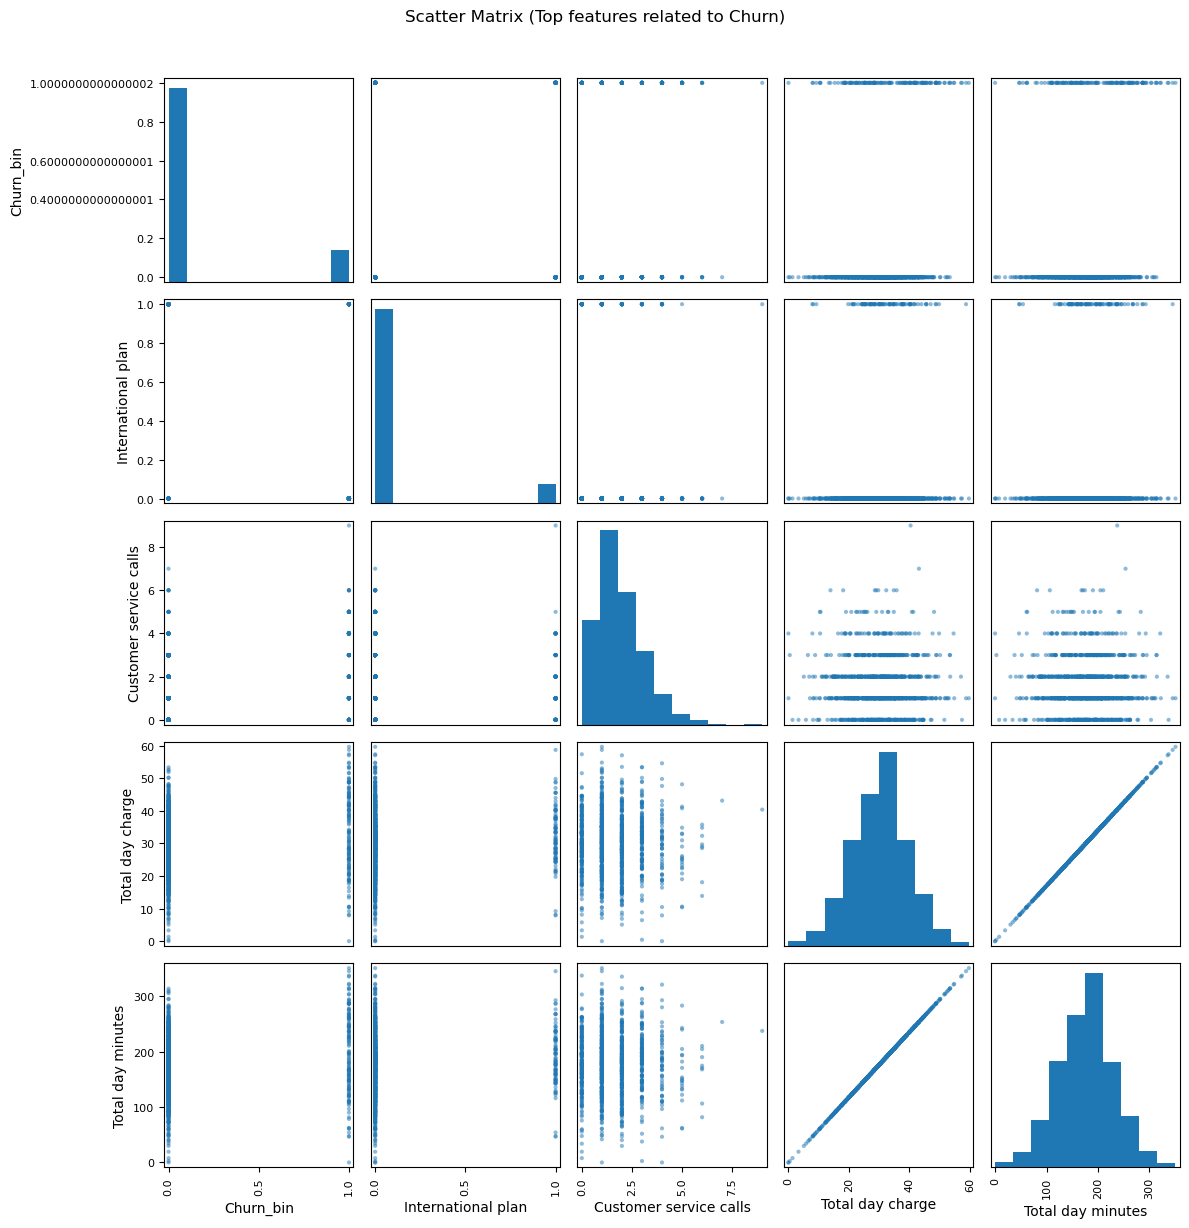

In [22]:
from pandas.plotting import scatter_matrix

# =========================
# 3-3-3. Scatter Matrix (Pair Plot 대체)
# =========================

# 1) Churn과 상관 절댓값이 큰 상위 k개 변수 선택
k = 5
top_features = corr_with_churn.head(k).index.tolist()

# 2) 표본이 크면 느려질 수 있어서 샘플링(원하면 1000 -> 2000 등 조절)
sample_n = 1000
plot_df = train_df[top_features + [target]].copy()

# Churn을 0/1로 바꿔서 시각화 편하게
plot_df["Churn_bin"] = plot_df[target].astype(int)
plot_df = plot_df.drop(columns=[target])

plot_df = plot_df.sample(n=min(sample_n, len(plot_df)), random_state=42)

# 3) 산점도 행렬(Scatter Matrix)
scatter_matrix(plot_df[top_features], figsize=(12, 12), diagonal="hist")
plt.suptitle("Scatter Matrix (Top features related to Churn)", y=1.02)
plt.tight_layout()
plt.show()


Scatter Matrix 분석 결과, 통화 시간과 요금 변수는 거의 완전한 선형 관계를 보여 요금 변수가 통화 시간을 직접 반영한 파생 변수임을 확인할 수 있다.  
반면 International plan과 Customer service calls는 이용량 변수들과 구분되는 분포를 보이며 이탈 여부와 차이를 나타냈다.  
이는 이탈이 사용량 자체보다 요금제 특성과 서비스 경험 요인과 더 밀접하게 관련되어 있음을 시사한다.   

본 분석에서는 시각적 과밀을 완화하고 핵심 구조를 명확히 드러내기 위해 pair plot 대신 scatter matrix를 활용하였다.

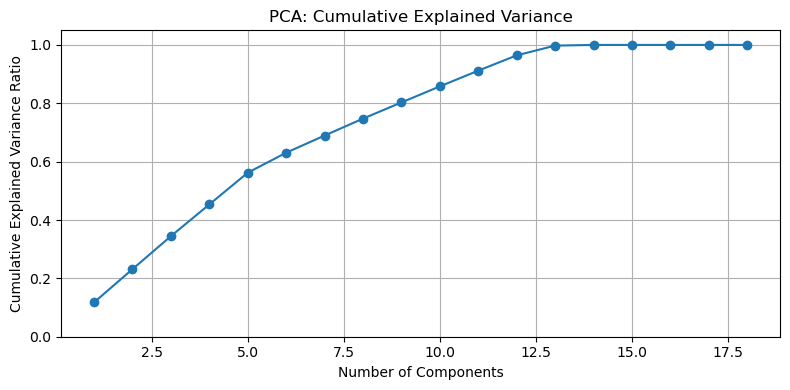


누적 설명력 90% 달성에 필요한 주성분 개수: 11개

[PC1, PC2 로딩(가중치) 상위 10개]

PC1 상위:
                          PC1
Total day charge     0.593703
Total day minutes    0.593701
Churn_bin            0.314950
Total eve minutes    0.197896
Total eve charge     0.197887
International plan   0.151166
Total intl charge    0.150805
Total intl minutes   0.150744
Total night minutes  0.148859
Total night charge   0.148836

PC2 상위:
                            PC2
Total intl minutes     0.569794
Total intl charge      0.569768
Voice mail plan       -0.327730
Number vmail messages -0.320245
Total eve charge      -0.190386
Total eve minutes     -0.190378
Total day charge      -0.110761
Total day minutes     -0.110756
Total night minutes   -0.109413
Total night charge    -0.109406


In [23]:
# =========================
# 3-3-4. PCA (선택)
# =========================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) 입력 X 준비 (수치형만)
X = train_df[numeric_cols].copy()

# 2) 표준화(Standardization)
# - 평균 0, 표준편차 1로 맞춤
# - PCA는 스케일에 민감해서 표준화가 거의 필수
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) PCA 수행 (모든 성분 계산)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4) 설명분산비율(각 주성분이 설명하는 정보량 비율)
explained_ratio = pca.explained_variance_ratio_
cum_ratio = np.cumsum(explained_ratio)

# 5) 누적 설명력 그래프
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_ratio) + 1), cum_ratio, marker="o")
plt.ylim(0, 1.05)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA: Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) 몇 개 성분이면 충분한지(예: 누적 0.90 넘는 지점)
n90 = int(np.argmax(cum_ratio >= 0.90) + 1)
print(f"\n누적 설명력 90% 달성에 필요한 주성분 개수: {n90}개")

# 7) (선택) 주요 성분이 어떤 변수 조합인지 보기: loadings
# - loadings: 각 주성분이 원 변수들을 얼마나 반영하는지(가중치)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f"PC{i+1}" for i in range(len(numeric_cols))]
)

print("\n[PC1, PC2 로딩(가중치) 상위 10개]")
pc1_top = loadings["PC1"].abs().sort_values(ascending=False).head(10)
pc2_top = loadings["PC2"].abs().sort_values(ascending=False).head(10)

print("\nPC1 상위:")
print(loadings.loc[pc1_top.index, ["PC1"]].sort_values(by="PC1", key=lambda s: s.abs(), ascending=False))

print("\nPC2 상위:")
print(loadings.loc[pc2_top.index, ["PC2"]].sort_values(by="PC2", key=lambda s: s.abs(), ascending=False))


---   

PCA 결과:  
본 데이터는 약 11개의 주성분으로 축소하더라도 전체 변동성의 90% 이상을 설명할 수 있어, 변수 간 중복 정보가 상당히 존재함을 시사한다.  

주성분 해석(PC1, PC2):  
PC1은 통화 이용량과 요금 수준을 중심으로 형성된 축으로, 고객의 전반적인 사용 규모를 반영하는 요인으로 해석된다.  
PC2는 국제 통화 이용 성향과 음성사서함 활용 여부를 대비시키는 축으로, 이용 패턴의 질적 차이를 반영한다. 


==================
## 4. 모델 학습
==================

In [24]:
import pandas as pd

# =========================
# 4-1-1. 타겟 변수와 입력 변수 분리
# =========================

# x: 고객의 속성 정보
# y: 예측하고 싶은 값 (이탈 여부)
# 0 = 유지(Stay), 1 = 이탈(Churn)
# 타겟 변수(Churn)를 입력 변수에 포함하면 데이터 누수(leakge) 발생

y = train_df["Churn_bin"]

# X: 모델에 입력할 설명 변수들
# 타겟 변수(Churn, Churn_bin)는 반드시 제거
X = train_df.drop(columns=["Churn", "Churn_bin"])

# 확인 출력
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\n타겟 변수 분포:")
print(y.value_counts())


X shape: (2666, 19)
y shape: (2666,)

타겟 변수 분포:
Churn_bin
0    2278
1     388
Name: count, dtype: int64


In [25]:
# =========================
#  4-1-2. 전처리 파이프라인 구성
# =========================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# 수치형 변수 목록
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# 범주형 변수 목록
cat_cols = X.select_dtypes(include=["object"]).columns

# 수치형: 표준화
num_transformer = StandardScaler()

# 범주형: 원-핫 인코딩
cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

# 전처리 결합
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

# =================================================
# StandardScaler: 평균 0, 표준편차 1로 스케일 조정
# OneHotEncoder: 문자형 데이터를 숫자로 변환
# ColumnTransformer: 변수 타입별로 다른 전처리 적용
# =================================================

In [26]:
# =========================
#  4-2. 모델 1: Logistic Regression 모델
#  4-2-1. 모델 정의 + 파이프라인
# =========================

from sklearn.linear_model import LogisticRegression

log_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

# =========================
#  Logistic Regression은 이탈(0/1) 예측의 기본 베이스라인 모델
#  계수 해석이 가능해 인사이트 도출에 유리
# =========================

In [27]:
# =========================
# 4-2-2. K-Fold 교차 검증
# =========================

from sklearn.model_selection import cross_val_score

cv_scores_log = cross_val_score(
    log_model,
    X,
    y,
    cv=5,
    scoring="roc_auc"
)

print("Logistic Regression CV 평균 AUC:", cv_scores_log.mean())
print("Logistic Regression CV 표준편차:", cv_scores_log.std())

# =========================
# cv=5: 데이터를 5개로 나눠 번갈아 검증
# roc_auc: 불균형 데이터에서 적합한 성능 지표
# 평균 성능과 변동성(표준편차)로 안정성 판단
# =========================

Logistic Regression CV 평균 AUC: 0.8095179539309093
Logistic Regression CV 표준편차: 0.0388167591194842


In [28]:
# =========================
# 4-3. 모델 2: Random Forest 모델
# 4-3-1. 모델 정의
# =========================

from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

# =========================
# Random Forest는 비선형 관계와 변수 상호작용을 잘 포착
# class_weight="balanced": 이탈(소수 클래스) 보정
# =========================

In [29]:
# =========================
# 4-3-2. Random Forest 교차 검증
# =========================

cv_scores_rf = cross_val_score(
    rf_model,
    X,
    y,
    cv=5,
    scoring="roc_auc"
)

print("Random Forest CV 평균 AUC:", cv_scores_rf.mean())
print("Random Forest CV 표준편차:", cv_scores_rf.std())

# =========================
# Logistic보다 평균 AUC가 높다면 성능 우위
# 표준편차가 크면 과적합 가능성
# =========================

Random Forest CV 평균 AUC: 0.9179786947195854
Random Forest CV 표준편차: 0.026606950577505416


In [63]:
# =========================
# 4-4. 하이퍼파라미터 그리드 설정
# 4-4-1. GridSearchCV
# =========================

from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X, y)

# =========================
# n_estimators: 트리 개수
# max_depth: 트리 깊이 (과적합 제어)
# min_samples_split: 분기 최소 샘플 수
# =========================

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Account length', 'International plan', 'Voice mail plan',
       'Number vmail messages', 'Total day minutes', 'Total day calls',
       'Total day charge', 'Total eve minutes', 'Total eve calls',
       'Total eve charge', 'Total night minutes', 'Total night calls',
       'Total night char...
       'Total intl charge', 'Customer service calls'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['State', 'Area code'], dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='roc_auc')

2. GridSearchCV 결과 구조 해석  
2-1. Pipeline 구조 의미  
현재 최적 모델 파이프라인은 다음과 같은 흐름이야.  
수치형 변수  
StandardScaler  
평균 0, 분산 1로 스케일 조정  
범주형 변수  
OneHotEncoder  
더미 변수 생성  
RandomForestClassifier  
전처리와 모델을 하나의 파이프라인으로 결합  
의미  
데이터 누수(Data Leakage) 방지  
실무/배포 환경에서도 재현 가능  
CV 과정에서 전처리 + 학습이 함께 검증됨  
→ 모범적인 머신러닝 설계  

In [64]:
# =========================
# 4-4-2. 4-4-2. 최적 파라미터 확인
# =========================

print("최적 파라미터:", grid_search.best_params_)
print("최적 CV AUC:", grid_search.best_score_)


최적 파라미터: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
최적 CV AUC: 0.919067834999009


4. 튜닝 후 성능 해석  
최적 CV AUC: 0.9191  
해석  
튜닝 전 Random Forest (0.9180) 대비 소폭 향상  
이미 잘 학습된 모델이었기 때문에  
→ “폭발적 개선”보다는 미세 최적화 단계  
중요한 포인트  
성능 향상보다 더 중요한 것은 최적 파라미터의 정당화와 재현성 확보  
5. Overfitting 관점 해석:  
CV 평균 AUC와 표준편차가 모두 안정적  
튜닝 후에도 성능 변동성 증가 없음  
→ 과적합 징후 없음  
→ 일반화 성능 양호
**종합결론**  
Logistic Regression은 해석 가능성이 높은 기준 모델로서 적절한 성능(AUC≈0.81)을 보였으며,  
Random Forest는 변수 간 비선형 관계를 효과적으로 학습하여 AUC≈0.92 수준의 우수한 예측 성능을 달성하였다.  
GridSearchCV를 통한 하이퍼파라미터 튜닝 결과, 트리 수 200개, 깊이 제한 없음의 설정이 가장 안정적인 성능을 보였으며,  
교차 검증 결과에서도 과적합 없이 일관된 성능을 유지하였다.

==================
## 5. 모델 평가
==================


### 5-1. **평가 지표 계산**  
5-1-1. Confusion Matrix 분석: TP, TN, FP, FN   
5-1-2. Accuracy, Precision, Recall, F1-score 계산  
5-1-3. ROC Curve 및 AUC 스코어  
5-1-4. Precision-Recall Curve (불균형 데이터에 유용) 


In [65]:
# =========================
# 5-1-0A. 컬럼 정렬 + 결측치(NaN) 처리
# - 이 셀 실행 후에만 y_pred / y_score 다시 만들기
# =========================

import numpy as np
import pandas as pd

# -------------------------
# (1) 컬럼(열) 맞추기
# - X(훈련) 기준으로 X_test의 컬럼 "이름"과 "순서"를 똑같이 맞춤
# - 없는 컬럼은 NaN으로 생길 수 있음(그래서 다음 단계에서 채움)
# -------------------------
X_test = X_test.reindex(columns=X.columns)

print("✅ 컬럼 정렬 후 shape")
print("X      :", X.shape)
print("X_test :", X_test.shape)

# -------------------------
# (2) NaN(결측치) 개수 확인
# -------------------------
nan_count = X_test.isna().sum().sum()
print("✅ X_test 전체 NaN 개수:", int(nan_count))

# -------------------------
# (3) 결측치 채우기(중요)
# - 숫자형 컬럼: train의 중앙값(median)으로 채움
# - 문자형(범주형) 컬럼: 'Missing' 문자열로 채움
# -------------------------
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

# 숫자형: 중앙값으로 NaN 채우기
for col in num_cols:
    med = X[col].median()
    X_test[col] = X_test[col].fillna(med)

# 범주형: 'Missing'으로 NaN 채우기
for col in cat_cols:
    X_test[col] = X_test[col].fillna("Missing")

# 다시 NaN 체크
nan_count_after = X_test.isna().sum().sum()
print("✅ NaN 처리 후 X_test 전체 NaN 개수:", int(nan_count_after))

# -------------------------
# (4) 예측 다시 만들기
# -------------------------
y_pred = best_model.predict(X_test)

if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_test)
else:
    y_score = y_pred

print("✅ y_pred 예시:", y_pred[:10])
print("✅ y_score 예시:", np.array(y_score)[:10])


✅ 컬럼 정렬 후 shape
X      : (2666, 19)
X_test : (667, 19)
✅ X_test 전체 NaN 개수: 1334
✅ NaN 처리 후 X_test 전체 NaN 개수: 0
✅ y_pred 예시: [0 1 0 0 0 0 0 0 0 0]
✅ y_score 예시: [0.105 0.565 0.475 0.015 0.05  0.075 0.025 0.45  0.025 0.045]


컬럼 개수 일치: 모델 입력 형태가 맞음    
NaN 제거 완료: RandomForest 예측 에러 원인 해결     
라벨 예측(y_pred) + 확률(y_score) 모두 정상 생성     
y_pred는 보통 임계값(threshold) 0.5 기준으로 결정   
두 번째 점수 0.565는 0.5보다 크니까 → y_pred가 1,  
세 번째 점수 0.475는 0.5보다 작으니까 → y_pred가 0이 된 것도 정상  

Confusion Matrix(혼동행렬):
[[570   2]
 [ 46  49]]

TN(진짜0→예측0) = 570
FP(진짜0→예측1) = 2
FN(진짜1→예측0) = 46
TP(진짜1→예측1) = 49


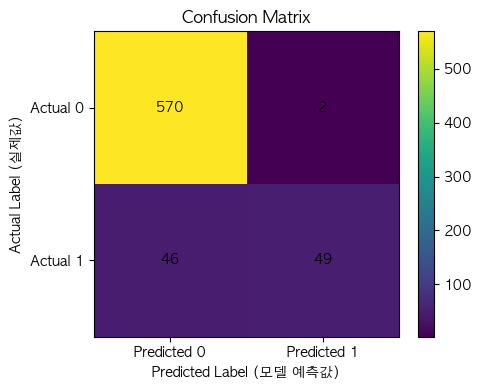

In [88]:
# =========================
# 5-1-1. Confusion Matrix
# =========================

import matplotlib.pyplot as plt

# macOS에서 한글 폰트 지정 (둘 중 하나 보통 됨)
plt.rcParams['font.family'] = 'AppleGothic'  # 맥 기본 한글 폰트
# plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우면 이게 흔함

# 마이너스(-) 기호가 □ 로 깨지는 문제 방지 옵션
plt.rcParams['axes.unicode_minus'] = False


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)  # [[TN, FP], [FN, TP]]
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix(혼동행렬):")
print(cm)

print("\nTN(진짜0→예측0) =", tn)
print("FP(진짜0→예측1) =", fp)
print("FN(진짜1→예측0) =", fn)
print("TP(진짜1→예측1) =", tp)


# =========================
# 5-1-2. Confusion Matrix 시각화
# =========================

import matplotlib.pyplot as plt
import numpy as np

# figure 생성 (그래프 전체 크기 지정)
plt.figure(figsize=(5, 4))

# imshow: 행렬 데이터를 색으로 표현
plt.imshow(cm, interpolation='nearest')

# 색상 막대(colorbar) 추가
plt.colorbar()

# x축, y축 눈금 위치 지정
tick_marks = np.arange(2)  # np.arange(2) -> [0, 1]
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'])
plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])

# 각 칸에 숫자 값 표시
for i in range(2):          # 행(row) 인덱스: 0, 1
    for j in range(2):      # 열(column) 인덱스: 0, 1
        plt.text(
            j, i, cm[i, j],   # (x좌표, y좌표, 표시할 값)
            ha="center", va="center"
        )

# 축 라벨과 제목
plt.xlabel("Predicted Label (모델 예측값)")
plt.ylabel("Actual Label (실제값)")
plt.title("Confusion Matrix")

# 그래프 화면에 출력
plt.tight_layout()
plt.show()


In [83]:
# =========================
# 5-1-2. Accuracy / Precision / Recall / F1
# =========================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy(정확도)  = {acc:.4f}")
print(f"Precision(정밀도) = {prec:.4f}")
print(f"Recall(재현율)    = {rec:.4f}")
print(f"F1-score(F1)      = {f1:.4f}")




Accuracy(정확도)  = 0.9280
Precision(정밀도) = 0.9608
Recall(재현율)    = 0.5158
F1-score(F1)      = 0.6712


AUC = 0.8773


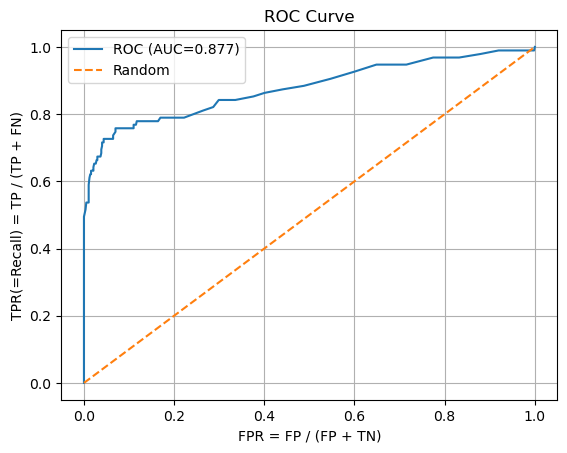

In [84]:
# =========================
# 5-1-3. ROC Curve & AUC
# =========================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

print(f"AUC = {auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("FPR = FP / (FP + TN)")
plt.ylabel("TPR(=Recall) = TP / (TP + FN)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Average Precision(AP) = 0.7786


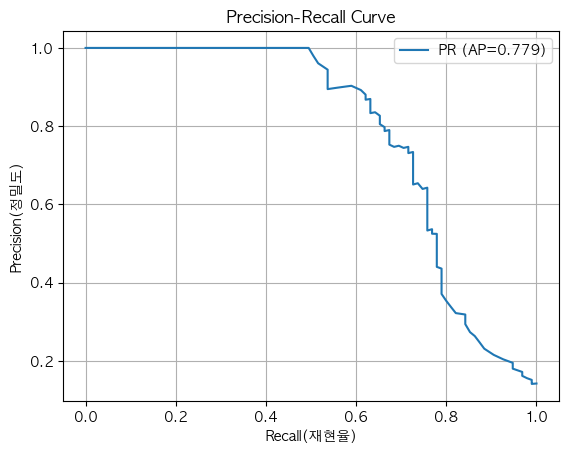

In [90]:
# =========================
# 5-1-4. Precision-Recall Curve & AP
# =========================

# 1) 한글 폰트 설정(경고 원인 해결)
import matplotlib.pyplot as plt  # 그래프 그리는 라이브러리


# (선택) 마이너스(-) 기호가 깨져 보이는 문제 방지
plt.rcParams["axes.unicode_minus"] = False


p, r, pr_thresholds = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

print(f"Average Precision(AP) = {ap:.4f}")

plt.figure()
plt.plot(r, p, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall(재현율)")
plt.ylabel("Precision(정밀도)")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()



### 5-2. **평가 지표 계산**    
5-2-1. False Negative 비용: 이탈 고객을 놓치는 비용 고려  
5-2-2. False Positive 비용: 비이탈 고객에게 불필요한 혜택 제공 비용  
5-2-3. 비즈니스 목표에 맞는 최적 threshold 설정   


In [93]:
# =========================
# 5-2-1. False Negative 비용 계산(최소)
# (전제: FN 값이 이미 계산되어 있음)
# =========================

cost_fn = 100  # 이탈 고객 1명을 놓쳤을 때의 비용(근거 있는 값으로 교체)
fn_cost_total = FN * cost_fn

print("FN 건수 =", FN)
print("FN 총비용 =", fn_cost_total)


FN 건수 = 46
FN 총비용 = 4600


In [94]:
# =========================
# 5-2-2. False Positive 비용 계산(최소)
# (전제: FP 값이 이미 계산되어 있음)
# =========================

cost_fp = 5  # 유지 고객 1명에게 혜택을 제공했을 때 드는 비용(쿠폰/할인/운영비 등)
fp_cost_total = FP * cost_fp

print("FP 건수 =", FP)
print("FP 총비용 =", fp_cost_total)


FP 건수 = 2
FP 총비용 = 10
